# Libraries and Global Settings

In [1]:
import pandas as pd  # work with Pandas dataframes
import numpy as np  # work with numpy arrays
from datetime import datetime # work with datetimes

import pandas_profiling # for EDA

import seaborn as sns # Visualizations 
#from sklearn import datasets
from yellowbrick.target import FeatureCorrelation # Visualization for Features Selection
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats

from sklearn import preprocessing
from sklearn.impute import KNNImputer

import warnings # Funktionalität zur Unterdrückung von Warnungen
warnings.filterwarnings('ignore')

C:\Users\sveti\Anaconda3\envs\condatascience\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%%html
<style>
table {float:left}
</style>

# Business Understanding

## Business Case Definition and Understanding

This project is part of the module "Machine Learning" (ML) at the Hochschule der Medien Stuttgart in the summer semster 2020.  
In this case we have to realize a project in the context of ML. 
The topic of this project comprises the analysis of the air quality in the center of Stuttgart, especially at the measuring point Stuttgart-Neckartor. 

## Goal Definition

The goal of this project is to analyze the air pollution caused by particulates (Feinstaub) in conjuction with other air specific and traffic based features.  
Furthermore, we would like to detemine if a prediction of the air pollution based on these features is possible.  
The use case of this prediction is to deliver valuable information for the warning system in Stuttgart. 

## Metrics Specification for Performance Measuring

The data samples consist of the target values for particulates and the features used as input parameters for the forecasting of our target values.  

| Column name | Additional information | Description |  Used As | 
| :------- | :------: | :------- | :-------  |
| Datum		 |  |  Datum | Feature | 
| Temp. (°C)	| Mittel	| Lufttemperatur|  Feature |
| Temp. (°C).1	| Max	| Lufttemperatur|  Feature |
| Temp. (°C).2	| Min	| Lufttemperatur|  Feature |
| Feuchte (%)	| Mittel	| Relative Luftfeuchte|  Feature |
| WG (m/s)	| Mittel	| Windgeschwindigkeit|  Feature |
| WG (m/s).1	| Max	| Windgeschwindigkeit|  Feature |
| WR (Grad)	| Mittel	| Windrichtung|  Feature |
| Druck (hPa)	| Mittel	| Absoluter Luftdruck|  Feature |
| Niederschlag (l/m²)	| Summe	| Niederschlag|  Feature |
| Globalstr. (W/m²)	| Mittel	| Globalstrahlung|  Feature |
| Str.-Bilanz (W/m²)	| Mittel	| Strahlungsbilanz|  Feature |
| UVA-Str. (W/m²)	| Mittel	| UV-A Strahlung|  Feature |
| UVB-Str. (W/m²)	| Mittel	| UV-B  Strahlung|  Feature |
| NO (µg/m³)	| Mittel	| Stickstoffmonoxid|  Feature |
| NO2 (µg/m³)	| Mittel	| Stickstoffdioxid|  Feature |
| O3 (µg/m³)	| Mittel	| Ozon|  Feature |
| PM10 (µg/m³)	| Mittel	| Feinstaub (PM10)| Outcome Variable |
| PM2,5 (µg/m³)	| Mittel	| Feinstaub (PM2.5)| not relevant |
| Verkehraufkommen	| Summe	| Verkehraufkommen |  Feature |



# Data Understanding

data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

## Data Gathering

Air data:

In [3]:
# https://www.stadtklima-stuttgart.de/index.php?luft_messdaten_download

Traffic data:

In [4]:
# https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Aktuell/zaehl_aktuell_node.html?nn=1819516&cms_detail=8440&cms_map=0

## Data Access

In [5]:
# define funktion to import each ExcelTab in one pandas dataframe
def excelImport(list_1, path_1, list_2, path_2):
    for i in list_1:
        if i == 2000:
            df = pd.read_excel(path_1, sheet_name=str(i), header=6)
            df = df.dropna(subset=['Datum'])
        else:
            df_temp = pd.read_excel(path_1, sheet_name=str(i), header=6)
            df_temp = df_temp.dropna(subset=['Datum'])
            df = df.append(df_temp, sort=False, ignore_index=True)
        #print(str(i))
    for j in list_2:
        df_temp2 = pd.read_excel(path_2, sheet_name=j, header=6)
        df_temp2 = df_temp2.rename(columns={"PM2,5 (µg/m³)": "PM2.5 (µg/m³)"})
        df_temp2 = df_temp2.dropna(subset=['Datum'])
        df = df.append(df_temp2, sort=False, ignore_index=True)
        #print(j)
    return df

In [6]:
list_1 = list(range(2000, 2020, 1))
list_2 = ["Jan. 2020", "Feb. 2020", "März 2020", "April 2020", "Mai 2020"]
path_1 = "Data/SZ-Tages-Werte-2000-2019.xlsx"
path_2 = "Data/S-Mitte-SZ-Tages-Werte-2020.xlsx"

df_air = excelImport(list_1, path_1, list_2, path_2)

In [7]:
df_air.head(5)

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,UVB-Str. (W/m²),NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³)
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,0.031,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,0.04113,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,0.02885,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,0.0351,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,0.03395,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN


In [8]:
df_air['Datum'][0]

Timestamp('2000-01-01 00:00:00')

In [9]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7457 entries, 0 to 7456
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7457 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   object        
 2   Temp. (°C).1         7334 non-null   object        
 3   Temp. (°C).2         7320 non-null   object        
 4   Feuchte (%)          6987 non-null   object        
 5   WG (m/s)             7433 non-null   object        
 6   WG (m/s).1           7347 non-null   object        
 7   WR (Grad)            7433 non-null   object        
 8   Druck (hPa)          7299 non-null   object        
 9   Globalstr. (W/m²)    7283 non-null   object        
 10  UVA-Str. (W/m²)      7254 non-null   object        
 11  UVB-Str. (W/m²)      7253 non-null   object        
 12  NO (µg/m³)           6755 non-null   object        
 13  NO2 (µg/m³)          6742 non-nul

In [10]:
df_air['Datum'] = df_air['Datum'].dt.normalize()
#df_air['Datum'] = df_air['Datum'].dt.date

In [11]:
df_air.head(5)

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,UVB-Str. (W/m²),NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³)
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,0.031,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,0.04113,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,0.02885,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,0.0351,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,0.03395,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN


In [12]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7457 entries, 0 to 7456
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7457 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   object        
 2   Temp. (°C).1         7334 non-null   object        
 3   Temp. (°C).2         7320 non-null   object        
 4   Feuchte (%)          6987 non-null   object        
 5   WG (m/s)             7433 non-null   object        
 6   WG (m/s).1           7347 non-null   object        
 7   WR (Grad)            7433 non-null   object        
 8   Druck (hPa)          7299 non-null   object        
 9   Globalstr. (W/m²)    7283 non-null   object        
 10  UVA-Str. (W/m²)      7254 non-null   object        
 11  UVB-Str. (W/m²)      7253 non-null   object        
 12  NO (µg/m³)           6755 non-null   object        
 13  NO2 (µg/m³)          6742 non-nul

In [13]:
df_air['Datum'][0]

Timestamp('2000-01-01 00:00:00')

Import function to import the traffic data 

In [14]:
def trafficImport(path, listYear):
    mydateparser = lambda x: pd.datetime.strptime(x, "%y%m%d")
    
    for i in listYear:
        
        path_full = path + str(i) + ".csv"    
    
        if i == 2003:
            df_traffic = pd.read_csv(path_full,
                         header=0,
                         sep=";",
                         parse_dates=['Datum'],
                         date_parser=mydateparser,
                         index_col=['Datum'])   
        
        else:
            df_traffic_temp = pd.read_csv(path_full,
                         header=0,
                         sep=";",
                         parse_dates=['Datum'],
                         date_parser=mydateparser,
                         index_col=['Datum'])
            df_traffic = df_traffic.append(df_traffic_temp, sort=False)
            
    df_traffic = df_traffic[["KFZ_R1", "KFZ_R2"]]
    df_traffic = df_traffic.resample('d').sum()
    df_traffic.loc[:,'KFZ_ges'] = df_traffic.loc[:,'KFZ_R1'].add(df_traffic.loc[:,'KFZ_R2'])
    df_traffic = df_traffic[["KFZ_ges"]] 
    return df_traffic

In [15]:
path = "Data/zst8440_"
listYear = list(range(2003, 2019, 1))

df_traffic = trafficImport(path, listYear)

In [16]:
df_traffic.tail(5)

,KFZ_ges
Datum,
2018-12-27,63079
2018-12-28,63118
2018-12-29,54339
2018-12-30,41674
2018-12-31,37776


Merge function to merge the two dataframes to one:

In [17]:
df_total = pd.merge(df_air, df_traffic, how='outer', on='Datum')

In [18]:
df_total.head()

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN,NaN


## Data Description and Understanding

### Data Quantity

### Data Quality

**Removal of dashes and double dashes**

In [19]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7458 entries, 0 to 7457
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7458 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   object        
 2   Temp. (°C).1         7334 non-null   object        
 3   Temp. (°C).2         7320 non-null   object        
 4   Feuchte (%)          6987 non-null   object        
 5   WG (m/s)             7433 non-null   object        
 6   WG (m/s).1           7347 non-null   object        
 7   WR (Grad)            7433 non-null   object        
 8   Druck (hPa)          7299 non-null   object        
 9   Globalstr. (W/m²)    7283 non-null   object        
 10  UVA-Str. (W/m²)      7254 non-null   object        
 11  UVB-Str. (W/m²)      7253 non-null   object        
 12  NO (µg/m³)           6755 non-null   object        
 13  NO2 (µg/m³)          6742 non-nul

In [20]:
df_total.loc[df_total['PM10 (µg/m³)'] == '--']

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
6222,2017-01-13,2.9,4.5,-9.4,57.5,4.9,13.8,224.4,965.63,27.3,...,NaN,NaN,45.8,NaN,NaN,0.08,-26.8,--,NaN,86737.0
6273,2017-03-05,8.6,12.8,5.7,60.7,2.8,8.4,241.5,971.63,120.2,...,0.4,9.3,54.7,NaN,NaN,1.3,36.7,--,--,57545.0
6284,2017-03-16,11.2,19.4,4.4,55.5,1.1,3.9,223.3,992.21,169.3,...,42,60.3,5.7,NaN,NaN,0,43.4,--,--,92500.0
6285,2017-03-17,13.4,20.6,8.8,52.8,2.3,7.7,231.2,983.81,137,...,18.1,29.6,34.6,NaN,NaN,0,40.1,--,--,91461.0
6286,2017-03-18,10,11.6,8.1,72.4,3,7.3,235.6,979.88,35.1,...,0.9,11.2,43.4,NaN,NaN,10.2,-14,--,--,69042.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7385,2020-03-21,5.4,11.2,3.1,81.9,2.9,7.1,61,989.83,14.1,...,1.7,13.4,9.5,NaN,NaN,13.9,-23.7,--,21.3,NaN
7386,2020-03-22,4.2,8.4,0.9,54.4,3.7,8.8,70,994.91,161.4,...,0.9,8.2,9.5,NaN,NaN,0.1,69.8,--,12.1,NaN
7393,2020-03-29,5.9,12.5,3.1,69.2,2.1,5.5,25,988.96,28.6,...,1,12.3,9.5,NaN,NaN,3.3,-21,--,--,NaN
7394,2020-03-30,3.7,7.9,0.2,48.7,2.8,8.3,211,993.51,166.2,...,1.8,15.4,9.5,NaN,NaN,0,93.4,--,--,NaN


In [21]:
df_total.replace("--", np.nan, inplace=True)

In [22]:
df_total

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,2000-01-01,3.718,5.700,2.1380,86.83,1.959896,7.450,234.922917,991.80,NaN,...,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.2990,90.69,2.172913,7.891,222.511250,996.90,NaN,...,NaN,NaN,16.91,10.74,0.8870,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.295208,6.030,220.181250,996.20,NaN,...,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.574979,9.703,220.885417,989.90,NaN,...,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.070,2.0340,83.52,2.237208,9.115,220.554167,989.70,NaN,...,NaN,NaN,16.03,14.27,1.1890,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7453,2020-05-28,17.300,21.800,12.4000,48.90,2.400000,6.100,28.000000,996.45,235.7,...,4.2,23.5,NaN,NaN,NaN,0.0,136.1,NaN,NaN,NaN
7454,2020-05-29,16.200,21.200,9.4000,44.80,2.200000,5.600,129.000000,993.43,237.9,...,2.8,18.7,NaN,NaN,NaN,0.0,105.5,NaN,NaN,NaN
7455,2020-05-30,15.900,20.600,9.3000,47.40,2.400000,7.100,27.000000,989.46,215.4,...,2.4,18.4,NaN,NaN,NaN,0.0,104.9,NaN,NaN,NaN
7456,2020-05-31,16.700,21.900,10.4000,42.70,2.000000,5.300,61.000000,988.27,258.8,...,1.6,13.0,NaN,NaN,NaN,0.0,131.8,NaN,NaN,NaN


In [23]:
df_total.loc[df_total['PM10 (µg/m³)'] == '--']

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [24]:
df_total.loc[df_total['PM10 (µg/m³)'] == '-'].head(5)

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
6044,2016-07-19,25.1,31.5,17.1,50.5,1.6,2.4,217.3,984.12,305.7,...,7.6,23.8,-,NaN,NaN,0.0,150.3,-,-,89889.0
6045,2016-07-20,27.6,34.7,18.8,45.6,1.6,2.7,217.6,979.71,300.2,...,5.5,21.3,-,NaN,NaN,0.0,148.4,-,-,88879.0
6361,2017-06-01,22.2,28.4,15.1,50.3,1.2,4.2,210.0,988.66,296.6,...,6.9,40.2,28.3,NaN,NaN,0.0,296.6,-,-,93576.0
6362,2017-06-02,22.9,29.3,19.8,54.4,1.3,7.0,231.0,985.61,211.0,...,5.8,42.4,33.9,NaN,NaN,0.0,211.0,-,-,92571.0
6363,2017-06-03,22.7,29.7,17.6,63.1,1.3,6.7,251.6,981.87,219.7,...,2.6,19.1,35.3,NaN,NaN,0.0,219.7,-,-,67340.0


In [25]:
df_total.replace("-", np.nan, inplace=True)

In [26]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7458 entries, 0 to 7457
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                7458 non-null   datetime64[ns]
 1   Temp. (°C)           7331 non-null   float64       
 2   Temp. (°C).1         7334 non-null   float64       
 3   Temp. (°C).2         7320 non-null   float64       
 4   Feuchte (%)          6987 non-null   float64       
 5   WG (m/s)             7433 non-null   float64       
 6   WG (m/s).1           7347 non-null   float64       
 7   WR (Grad)            7433 non-null   float64       
 8   Druck (hPa)          7299 non-null   float64       
 9   Globalstr. (W/m²)    7283 non-null   float64       
 10  UVA-Str. (W/m²)      7254 non-null   float64       
 11  UVB-Str. (W/m²)      7253 non-null   float64       
 12  NO (µg/m³)           6710 non-null   float64       
 13  NO2 (µg/m³)          6697 non-nul

In [27]:
df_total.describe()

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
count,7331.000000,7334.000000,7320.000000,6987.000000,7433.000000,7347.000000,7433.000000,7299.000000,7283.000000,7254.000000,...,6710.000000,6697.000000,6960.00000,3136.000000,1277.000000,6969.000000,6727.000000,5843.000000,1451.000000,5845.000000
mean,12.035986,16.741980,7.934110,66.402367,1.981501,7.621054,194.121793,984.818118,127.758414,6.877872,...,20.574591,33.648300,23.00428,6.653081,0.390354,1.430604,35.176040,20.300021,12.529251,73857.716339
std,7.451711,8.826068,6.605726,12.034543,0.728233,3.329142,61.581520,7.769937,89.669255,4.079769,...,27.214104,16.616004,14.36668,6.241966,0.386438,3.433907,64.052121,11.865320,8.875281,15191.233885
min,-11.430000,-7.732000,-14.280000,0.051950,0.600000,1.300000,2.300000,947.400000,0.855200,0.620000,...,-5.069000,-8.038000,0.00000,-3.913000,0.023830,0.000000,-501.000000,-64.060000,0.000000,26533.000000
25%,6.200500,9.690500,2.888000,57.455000,1.500000,5.197000,153.640827,980.500000,48.605000,3.500250,...,5.059250,21.830000,11.60000,1.823750,0.106500,0.000000,-6.274000,12.570000,7.100000,61707.000000
50%,12.210000,16.950000,8.041500,67.270000,1.800000,7.009000,211.135417,985.400000,110.500000,5.857500,...,10.995000,31.250000,21.24000,5.150000,0.212500,0.040000,23.090000,18.110000,10.900000,79446.000000
75%,17.800000,23.540000,13.220000,75.600000,2.300000,9.409000,234.539583,989.800000,198.000000,9.485000,...,24.927500,42.950000,31.20000,10.320000,0.599100,1.160000,73.195000,25.365000,15.650000,85504.000000
max,31.460000,39.540000,24.200000,95.030000,7.155542,24.440000,359.700000,1011.300000,422.900000,26.500000,...,345.900000,138.800000,99.93000,44.690000,2.984000,51.100000,1079.000000,211.700000,185.199375,99162.000000


A copy of the original df_total is created for later use, especially for the comparisons when dataframe is further processed (e.g handling of missing values). In particular we want to show that character of the dataset keeps unchanged.

In [28]:
df_total_original=df_total

## Exploratory Data Analysis

### EDA Preparation

In order to do a quick exploratory data analysis we use the open source Python module Pandas profiling.  
With this module we are able to create interactive statistical reports and visualizations in a web format.

In [ ]:
eda=pandas_profiling.ProfileReport(df_total)
#eda
eda.to_file(output_file="AirQualityStuttgartEDA.html")

The results of the EDA can be found [here](AirQualityStuttgartEDA.html).

### Result Summary

#### Weather

##### Temperature

All three temperature variables are highly correlated because they represent the `mean`, `max` and `min` values per day.   
For our use case the `mean` values are appropriate and therefore in the following we will drop the `min` and `max` variables. 

The `missing values` of 127 will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).  


##### Radiation

The four radiation parameters `Str.-Bilanz (W/m²)`, `Globalstr. (W/m²)`, `UVA-Str. (W/m²)`, and `UVB-Str. (W/m²)` are highly correlated because `UVA` and `UVB` are components of `Global Radiation` (Globalstrahlung), and all three are components of `Radiation Balance`.  

The *missing values* of 175 will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   

*Outliers* will be handled in the following chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling).  

As the four paramaters are intercorrelated we will chose one paramter during the [Features Selection](#Features-Selection).

##### Others

- *Wind* 

There are three wind specific variables. The two variables for `Wind speed` are representing mean and max values and are therefore highly correlated. 
For our use case the mean values are appropriate and therefore in the following we will drop the max variables.
The third one is representing the `Wind Direction`. This variable might have an hugh impact due to the special topography of the city Stuttgart.

The *missing values* will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   

*Outliers* will be handled in the chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling).  

As two paramaters are interconnected and there is an additial parameter for the wind direction we will select the relevant paramters during the [Features Selection](#Features-Selection).

- *Humidity, Rainfall, Pressure*

The `Rainfall` parameter is special in that way that there are many days without rain and these days are represented by zero values.  

The *missing values* will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   

*Outliers* will be handled in the chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling).  

The relevance of these two parameters will be analyzed in the chapter [Features Selection](#Features-Selection).



#### Emmissions

- *NO / NO2 / O3 / SO2 / CO*

Some parameters show some values with a negative sign.  This seems to be unplausible because these variables have units which comprise mass and volume and therefore cannot be negative.  
We assume that these negative values are false values which arose during the recordings and should be corrected. In our case we change the negative sign to positive. This is done in the chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling). 

- *PM10 & PM2.5*

Here again we have negative values which we will handle in the same way as described above.  
Particularly the PM2.5 parameter consists of few observations and therefore a completion for missing values makes no sense. 

For both areas we will do following tasks:  
The *missing values* will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   
The relevance will be analyzed in the chapter [Features Selection](#Features-Selection).

#### Traffic

There are missing values (1,613) due to missing data for the periods 2018-2020 & 2000-2002.

The *missing values* will be completed in the chapter [Detection of Missing Values](#Detection-of-Missing-Values).   

*Outliers* will be handled in the chapter [Outlier Detection and Handling](#Outlier-Detection-and-Handling).  

The relevance will be analyzed in the chapter [Features Selection](#Features-Selection).

# Data Preparation

## Detection of Missing Values

In the areas of detection and handling of missing values there is a variance of different approaches.  
One of the easiest ways is to delete the rows which contains missing values.  
In our case this approach would lead to the fact that our idea of performing a regression on the time series would not work properly.  
Therefore we chose another approach of handling missing values. 
There a different ways to complete the data set. Popular methods use imputer function to fill mean, median or most_frequent values. In our case we use a imputer functions which is based on the K-nearest neigbor algorithm and considers the context of data more accurately.

First of all in the dataframe df_total we drop the column "Datum" because the normalization function does not work on datetime data type and store it to a new dataframe df_total_woDate.  
We use the min_max_scaler to normalize the data.  
And finally we convert the normalized data represented by numpy array back to an pandas dataframe df_total_norm.

In [29]:
df_total_woDate = df_total_original.drop('Datum', axis=1)
x = df_total_woDate.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_total_norm = pd.DataFrame(x_scaled)

KNN Imputing is a complex method for imputing missing values using k-Nearest Neighbors, in which the KNN algorithm finds other data points similar to one with a missing value within multidimensional space. Further information can be found [here](https://scikit-learn.org/stable/modules/impute.html#knnimpute).

In [30]:
imputer = KNNImputer()
numData = imputer.fit_transform(df_total_norm)

Create a list of columns names to recover the pandas dataframe from the above created numpy array.

In [31]:
listColumns = list(df_total_woDate.columns)

Create the pandas dataframe with normalized values.

In [32]:
df_total_norm_KNN = pd.DataFrame(data=numData, columns=listColumns)

In [33]:
df_total_norm_KNN.head()

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,0.353183,0.284143,0.426663,0.913664,0.207442,0.265774,0.650876,0.694836,0.046035,0.077512,...,0.064666,0.219793,0.136095,0.294076,0.299669,0.070239,0.262878,0.273561,0.050621,0.624580
1,0.356214,0.305424,0.404860,0.954305,0.239936,0.284831,0.616148,0.774648,0.063872,0.133269,...,0.055155,0.250180,0.169218,0.301483,0.291595,0.068908,0.238530,0.277260,0.040728,0.566377
2,0.300606,0.220807,0.381726,0.931037,0.258592,0.204408,0.609629,0.763693,0.058996,0.068624,...,0.068760,0.295387,0.154108,0.292225,0.275515,0.016434,0.310873,0.304642,0.060373,0.528893
3,0.381534,0.327445,0.394044,0.814062,0.453811,0.363137,0.611599,0.665102,0.067925,0.093393,...,0.037995,0.219616,0.224457,0.356624,0.256191,0.029147,0.320451,0.273927,0.041480,0.794192
4,0.427769,0.376587,0.423960,0.878814,0.249744,0.337727,0.610672,0.661972,0.075450,0.090572,...,0.046781,0.233223,0.160412,0.374113,0.393616,0.084540,0.303405,0.279178,0.036069,0.671693


In the next step we denormalize the values:

In [34]:
numDenorm = min_max_scaler.inverse_transform(df_total_norm_KNN)
df_total_denorm_KNN  = pd.DataFrame(numDenorm, columns=listColumns)

We generate a dataframe with one column date to concat with our newly created dataframe of denormalized values.

In [35]:
df_total_Date = df_total[['Datum']]

In [36]:
df_total = pd.concat([df_total_Date, df_total_denorm_KNN], axis=1, sort=False)

In [37]:
df_total.head()

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,2000-01-01,3.718,5.700,2.1380,86.83,1.959896,7.450,234.922917,991.8,20.2840,...,17.6266,24.236,13.60,10.38,0.9109,3.5892,-85.6520,11.3772,9.3750,71895.6
1,2000-01-02,3.848,6.706,1.2990,90.69,2.172913,7.891,222.511250,996.9,27.8120,...,14.2886,28.698,16.91,10.74,0.8870,3.5212,-124.1220,12.3972,7.5428,67668.4
2,2000-01-03,1.463,2.706,0.4088,88.48,2.295208,6.030,220.181250,996.2,25.7540,...,19.0638,35.336,15.40,10.29,0.8394,0.8398,-9.8208,19.9480,11.1810,64946.0
3,2000-01-04,4.934,7.747,0.8828,77.37,3.574979,9.703,220.885417,989.9,29.5224,...,8.2660,24.210,22.43,13.42,0.7822,1.4894,5.3120,11.4780,7.6820,84214.4
4,2000-01-05,6.917,10.070,2.0340,83.52,2.237208,9.115,220.554167,989.7,32.6984,...,11.3496,26.208,16.03,14.27,1.1890,4.3200,-21.6198,12.9260,6.6800,75317.4


In [38]:
df_total.describe()

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
count,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,...,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000
mean,12.037186,16.741162,7.921511,66.493022,1.981211,7.645979,194.085750,984.837622,127.081256,6.886143,...,20.622069,33.543177,22.987206,6.555690,0.455946,1.429776,35.744829,19.559665,12.575459,73491.406081
std,7.414490,8.784031,6.567150,11.891172,0.727090,3.329761,61.500193,7.725808,89.175475,4.045396,...,26.771205,16.139952,14.077765,4.880320,0.296478,3.356878,63.374152,11.047138,6.227805,13980.740621
min,-11.430000,-7.732000,-14.280000,0.051950,0.600000,1.300000,2.300000,947.400000,0.855200,0.620000,...,-5.069000,-8.038000,0.000000,-3.913000,0.023830,0.000000,-501.000000,-64.060000,0.000000,26533.000000
25%,6.259250,9.750500,2.931250,57.700000,1.500000,5.197000,153.713579,980.585000,48.562500,3.536250,...,5.287000,22.260000,11.840000,3.107445,0.226937,0.000000,-6.246750,12.480000,8.411100,63845.250000
50%,12.205000,16.930000,8.002000,67.390000,1.800000,7.009000,211.071147,985.400000,109.900000,5.909400,...,11.165000,31.175000,21.465000,5.959850,0.393567,0.060000,23.830000,17.305000,11.460000,77316.500000
75%,17.730000,23.500000,13.170000,75.560000,2.300000,9.458000,234.489428,989.800000,196.800000,9.458750,...,24.995000,42.510000,30.887500,9.152800,0.625345,1.270000,74.417500,24.117500,15.500000,84217.500000
max,31.460000,39.540000,24.200000,95.030000,7.155542,24.440000,359.700000,1011.300000,422.900000,26.500000,...,345.900000,138.800000,99.930000,44.690000,2.984000,51.100000,1079.000000,211.700000,185.199375,99162.000000


## Adjustment of Negative Values

Before we deal with the actual outliers, we first solve the problem with errors that most likely occurred during the collection of data.<br>
The following variables contain negative values which we assume are documentation errors, as already described above.
- SO2 (µg/m³), 
- NO2 (µg/m³), 
- NO (µg/m³),
- PM10 (µg/m³)

Therefore, we will simply change the signs for the negative values.

In [39]:
#df_total[df_total['SO2 (µg/m³)']<0]
#df_total[df_total['NO2 (µg/m³)']<0]
#df_total[df_total['NO (µg/m³)']<0]
df_total[df_total['PM10 (µg/m³)']<0]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
1325,2003-08-18,23.660,29.74,19.260,56.77,3.270265,14.55,241.737500,986.8,225.2,...,-0.08451,24.800,64.98,0.916894,0.065700,5.0580,-30.1200,-4.315,6.1520,67244.0
1559,2004-04-08,6.756,11.14,3.945,64.81,2.536850,10.39,265.321277,980.7,158.7,...,8.01700,38.880,29.51,8.323000,0.076090,0.1600,59.5400,-64.060,9.7238,83633.0
1698,2004-08-25,18.190,21.92,0.000,58.35,3.624903,14.11,236.451613,981.5,247.2,...,8.65160,24.527,37.83,9.098020,0.041590,0.6935,41.0800,-25.190,10.2800,70514.0
2471,2006-10-07,14.240,17.48,10.100,70.50,2.999313,13.96,244.147917,983.5,111.7,...,9.33720,20.064,35.26,3.551000,0.092166,1.7200,0.1469,-1.308,7.3716,64404.0


In [40]:
def elNeSign (list_row_name):
    for i in list_row_name:
        df_total[i]=df_total[i].astype('str')
        df_total[i]=df_total[i].str.replace('-','')
        df_total[i]=df_total[i].astype('float')

list_row_name =['SO2 (µg/m³)', 'NO2 (µg/m³)', 'NO (µg/m³)', 'PM10 (µg/m³)']
elNeSign(list_row_name)

In [41]:
#df_total[df_total['SO2 (µg/m³)']<0]
#df_total[df_total['NO2 (µg/m³)']<0]
#df_total[df_total['NO (µg/m³)']<0]
df_total[df_total['PM10 (µg/m³)']<0]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [42]:
df_total.describe()

,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),UVA-Str. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
count,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,...,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000
mean,12.037186,16.741162,7.921511,66.493022,1.981211,7.645979,194.085750,984.837622,127.081256,6.886143,...,20.628170,33.558937,22.987206,6.631525,0.455946,1.429776,35.744829,19.585107,12.575459,73491.406081
std,7.414490,8.784031,6.567150,11.891172,0.727090,3.329761,61.500193,7.725808,89.175475,4.045396,...,26.766503,16.107154,14.077765,4.776749,0.296478,3.356878,63.374152,11.001963,6.227805,13980.740621
min,-11.430000,-7.732000,-14.280000,0.051950,0.600000,1.300000,2.300000,947.400000,0.855200,0.620000,...,0.047220,0.000000,0.000000,0.000000,0.023830,0.000000,-501.000000,0.000000,0.000000,26533.000000
25%,6.259250,9.750500,2.931250,57.700000,1.500000,5.197000,153.713579,980.585000,48.562500,3.536250,...,5.287000,22.260000,11.840000,3.138250,0.226937,0.000000,-6.246750,12.481200,8.411100,63845.250000
50%,12.205000,16.930000,8.002000,67.390000,1.800000,7.009000,211.071147,985.400000,109.900000,5.909400,...,11.165000,31.175000,21.465000,5.959850,0.393567,0.060000,23.830000,17.310000,11.460000,77316.500000
75%,17.730000,23.500000,13.170000,75.560000,2.300000,9.458000,234.489428,989.800000,196.800000,9.458750,...,24.995000,42.510000,30.887500,9.152800,0.625345,1.270000,74.417500,24.133000,15.500000,84217.500000
max,31.460000,39.540000,24.200000,95.030000,7.155542,24.440000,359.700000,1011.300000,422.900000,26.500000,...,345.900000,138.800000,99.930000,44.690000,2.984000,51.100000,1079.000000,211.700000,185.199375,99162.000000


## Outlier Detection and Handling

### Outlier Identification and Method Definition

With following Seaborn functions we can boxplot feature by feature and decide if there are outliers and if so how we want to treat them.

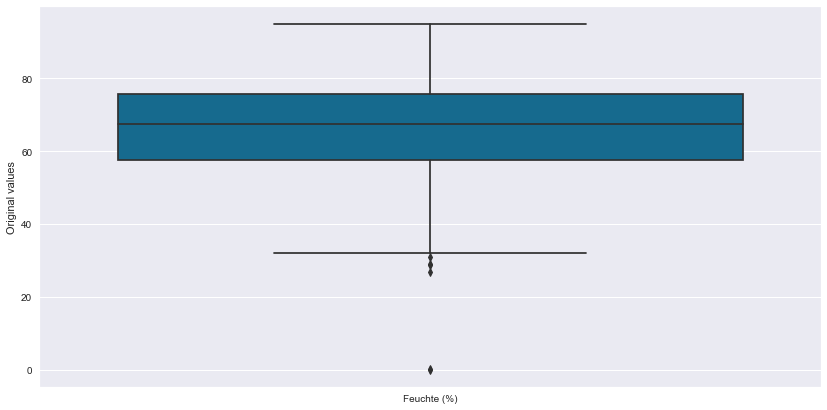

In [43]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    #'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

We developed three methods to treat outliers:
- Z score method
- Interquartile range (IQR) method
- Logarithm method

The hypothesis of z-score method in anomaly detection is that the data value is in a Gaussian distribution. It only works well if the outliers are one-sided. 

According to the EDA analysis we assume following feature nearly as Gaussian distrubuted (one could mathematically test this but due to time restriction we relied on the visual inspection) and therefore we will treat them with the `Z score`:
- Humidity
- Wind Speed
- Wind Direction
- NO2
- O3
- SO2
- Rainfall

No outliers therefore not treated (although Gaussian distributed):
- Temperature

The rest we will treat with the IQR method. The Log method won't be applied because it would change all the data. 
Following features will be handled with the `IQR method`:
- Pressure
- Global Radiation
- UVA Radiation
- UVB Radiation
- NO
- CO
- Radiation Balance
- PM2.5
- PM10
- Traffic Amount

The outlier detection must be viewed and edited column by column! We pass here the column that is processed to the variable `data` as a numpy Arrey.

### Outlier Handling Using Z Score

Formula for Z score = (Observation — Mean)/Standard Deviation

z = (X — μ) / σ

We find the z score for each of the data point in the dataset and if the z score is greater than 3 than we can classify that point as an outlier. Any point outside of 3 standard deviations would be an outlier.

In [44]:
def detect_outlier(data_1):
    outliers=[]
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

#### Humidity

In [45]:
data = df_total['Feuchte (%)'].values

In [46]:
outlier_datapoint = detect_outlier(data)
#outliers=[] # the list must be emptied, otherwise double entry of the values
min_val = min(outlier_datapoint)
max_val = max(outlier_datapoint)

print('Min value: ', min_val)
print('Max value: ', max_val)
print('All outliers: ', outlier_datapoint)

Min value:  0.05195
Max value:  29.020000000000003
All outliers:  [0.05743, 0.05195, 29.020000000000003, 28.63, 26.7]


***Replacing outliers with `min_val` and `max_val` respectivly***

In [47]:
#df_total.loc[df_total['Feuchte (%)'] > min_val,'Feuchte (%)'] = min_val

In [48]:
df_total.loc[df_total['Feuchte (%)'] < max_val,'Feuchte (%)'] = max_val

***Testing if there are outliers***

In [49]:
#df_total[df_total['Feuchte (%)'] > min_val]

In [50]:
df_total[df_total['Feuchte (%)'] < max_val]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Checking `Max Value` and `Mind Value`, `Boxplotting`***

In [51]:
max(df_total['Feuchte (%)'])

95.03

In [52]:
min(df_total['Feuchte (%)'])

29.020000000000003

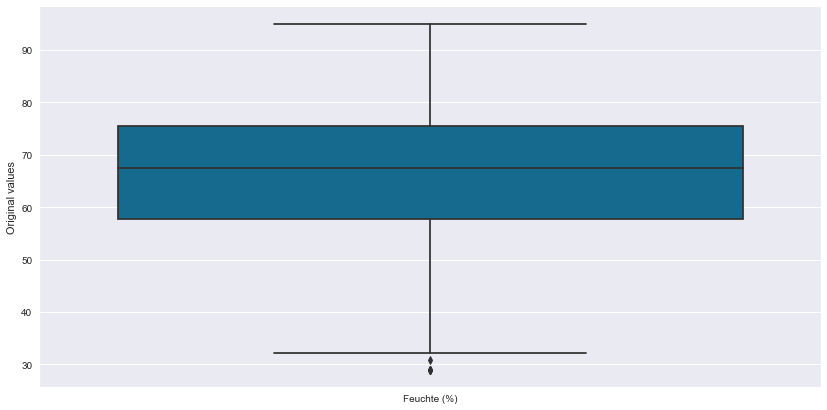

In [53]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    #'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### Wind Speed


In [54]:
data = df_total['WG (m/s)'].values

In [55]:
outlier_datapoint = detect_outlier(data)
min_val = min(outlier_datapoint)
max_val = max(outlier_datapoint)

print('Min value: ', min_val)
print('Max value: ', max_val)
print('All outliers: ', outlier_datapoint)

Min value:  4.166604166666667
Max value:  7.155541666666665
All outliers:  [5.954020833333332, 4.6130416666666685, 4.8475416666666655, 4.374937500000001, 4.5473541666666675, 4.197979166666667, 6.354854166666666, 4.5307916666666666, 4.2399375, 4.497625, 4.315312500000001, 4.623124999999999, 4.845333333333333, 4.845333333333333, 4.521541666666666, 4.166604166666667, 4.3536875, 6.020583333333332, 4.445708333333332, 4.884249999999999, 6.542354166666665, 5.094375, 4.506749999999999, 6.643437499999998, 4.672166666666667, 4.348708333333334, 4.8335625, 5.243895833333336, 4.745520833333333, 5.192395833333334, 4.300875, 4.879458333333333, 4.451020833333334, 4.337020833333333, 4.753458333333334, 5.292666666666668, 4.478895833333332, 4.403291666666666, 4.818416666666667, 5.456854166666666, 4.627604166666667, 4.3709791666666655, 4.496708333333333, 5.053645833333334, 4.944583333333333, 4.590708333333335, 5.066416666666666, 4.2456249999999995, 4.491833333333334, 4.521, 4.308895833333334, 4.2570499999

***Replacing outliers with `min_val` and `max_val` respectivly***

In [56]:
df_total.loc[df_total['WG (m/s)'] > min_val,'WG (m/s)'] = min_val

In [57]:
#df_total.loc[df_total['WG (m/s)'] < max_val,'WG (m/s)'] = max_val

***Testing if there are outliers***

In [58]:
df_total[df_total['WG (m/s)'] > min_val]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [59]:
#df_total[df_total['WG (m/s)'] < max_val]

***Checking `Max Value` and `Mind Value`, `Boxplotting`***

In [60]:
max(df_total['WG (m/s)'])

4.166604166666667

In [61]:
min(df_total['WG (m/s)'])

0.6

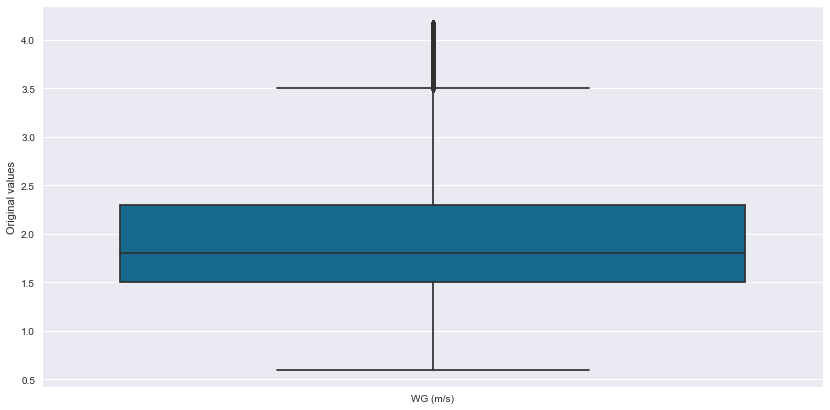

In [62]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    #'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

***`WG (m/s).1`***

In [63]:
data = df_total['WG (m/s).1'].values

In [64]:
outlier_datapoint = detect_outlier(data)
min_val = min(outlier_datapoint)
max_val = max(outlier_datapoint)

print('Min value: ', min_val)
print('Max value: ', max_val)
print('All outliers: ', outlier_datapoint)

Min value:  17.69
Max value:  24.439999999999998
All outliers:  [22.39, 18.08, 21.6, 18.57, 19.84, 19.64, 22.04, 19.35, 19.99, 19.2, 20.82, 18.22, 21.26, 19.11, 19.16, 24.439999999999998, 18.86, 19.25, 18.18, 18.71, 18.52, 19.74, 18.67, 22.0, 18.32, 18.13, 19.25, 19.45, 18.18, 17.73, 21.36, 19.6, 17.69, 20.82, 20.28, 20.92, 17.88, 19.16, 19.6, 18.42, 21.21, 20.53, 20.67, 21.36, 20.09, 21.41, 17.78, 20.18, 20.04, 20.97, 22.0, 23.81, 18.67, 17.88, 18.37, 24.439999999999998, 20.77, 21.11, 18.81, 18.08, 22.0, 21.8, 20.09, 20.87, 20.63, 20.13, 18.62, 18.52, 24.439999999999998, 18.37, 18.1, 17.69, 18.08, 20.58, 23.56, 18.52, 18.52, 20.4]


***Replacing outliers with `min_val` and `max_val` respectivly***

In [65]:
df_total.loc[df_total['WG (m/s).1'] > min_val,'WG (m/s).1'] = min_val

In [66]:
#df_total.loc[df_total['WG (m/s)'] < max_val,'WG (m/s)'] = max_val

***Testing if there are outliers***

In [67]:
df_total[df_total['WG (m/s).1'] > min_val]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [68]:
#df_total[df_total['WG (m/s)'] < max_val]

***Testing if the highest value in the row belowe is not higher then `min_val`***

In [69]:
max(df_total['WG (m/s).1'])

17.69

In [70]:
min(df_total['WG (m/s).1'])

1.3

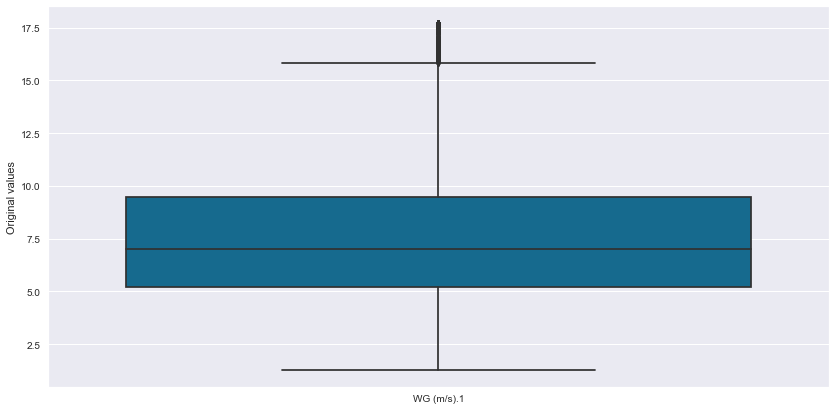

In [71]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    #'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### Wind Direction

In [72]:
data = df_total['WR (Grad)'].values

In [73]:
outlier_datapoint = detect_outlier(data)
min_val = min(outlier_datapoint)
max_val = max(outlier_datapoint)

print('Min value: ', min_val)
print('Max value: ', max_val)
print('All outliers: ', outlier_datapoint)

Min value:  2.3
Max value:  9.0
All outliers:  [5.5, 4.5, 5.3, 2.3, 8.0, 9.0, 8.0]


***Replacing outliers with `min_val` and `max_val` respectivly***

In [74]:
#df_total.loc[df_total['WR (Grad)'] > min_val,'WR (Grad)'] = min_val

In [75]:
df_total.loc[df_total['WR (Grad)'] < max_val,'WR (Grad)'] = max_val

***Testing if there are outliers***

In [76]:
#df_total[df_total['WR (Grad)'] > min_val]

In [77]:
df_total[df_total['WR (Grad)'] < max_val]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Checking `Max Value` and `Mind Value`, `Boxplotting`***

In [78]:
max(df_total['WR (Grad)'])

359.7

In [79]:
min(df_total['WR (Grad)'])

9.0

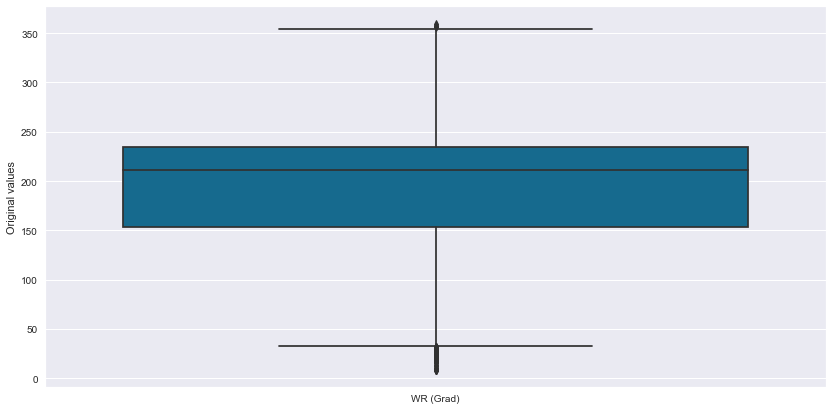

In [80]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    #'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### NO2

In [81]:
data = df_total['NO2 (µg/m³)'].values

In [82]:
outlier_datapoint = detect_outlier(data)
min_val = min(outlier_datapoint)
max_val = max(outlier_datapoint)

print('Min value: ', min_val)
print('Max value: ', max_val)
print('All outliers: ', outlier_datapoint)

Min value:  81.96999999999998
Max value:  138.8
All outliers:  [87.794, 87.38999999999999, 99.82999999999998, 99.27, 100.1, 89.6, 84.19200000000001, 89.66, 103.9, 102.49999999999997, 84.25999999999999, 94.78, 107.6, 83.52, 97.43999999999998, 91.94, 83.11999999999999, 89.01999999999998, 84.78999999999999, 98.46, 93.54, 90.98, 96.86999999999999, 81.96999999999998, 83.45999999999998, 88.07999999999997, 95.91, 93.74, 92.18, 84.58, 86.09, 85.51, 82.34, 87.19, 126.79999999999998, 112.69999999999999, 88.63, 85.34999999999998, 98.3, 95.75, 91.81999999999996, 105.4, 88.86, 91.29, 105.3, 118.69999999999999, 114.6, 103.99999999999997, 84.78999999999999, 89.79, 108.09999999999998, 95.61, 89.79999999999998, 95.44999999999997, 83.97, 124.59999999999998, 83.61, 98.08, 96.55999999999999, 113.49999999999999, 132.2, 135.6, 138.8, 109.9, 95.4, 87.73999999999998, 87.85999999999997, 85.60999999999997, 88.1, 93.76, 113.39999999999998, 89.38, 83.85999999999999, 93.98999999999998, 87.20999999999998, 83.140000

***Replacing outliers with `min_val` and `max_val` respectivly***

In [83]:
df_total.loc[df_total['NO2 (µg/m³)'] > min_val,'NO2 (µg/m³)'] = min_val

In [84]:
#df_total.loc[df_total['WG (m/s)'] < max_val,'WG (m/s)'] = max_val

***Testing if there are outliers***

In [85]:
df_total[df_total['NO2 (µg/m³)'] > min_val]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [86]:
#df_total[df_total['WG (m/s)'] < max_val]

***Checking `Max Value` and `Mind Value`, `Boxplotting`***

In [87]:
max(df_total['NO2 (µg/m³)'])

81.96999999999998

In [88]:
min(df_total['NO2 (µg/m³)'])

0.0

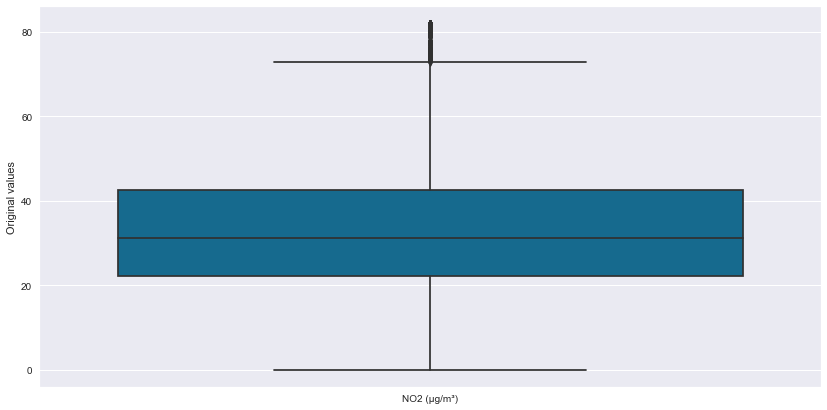

In [89]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    #'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### O3

In [90]:
data = df_total['O3 (µg/m³)'].values

In [91]:
outlier_datapoint = detect_outlier(data)
min_val = min(outlier_datapoint)
max_val = max(outlier_datapoint)

print('Min value: ', min_val)
print('Max value: ', max_val)
print('All outliers: ', outlier_datapoint)

Min value:  65.39
Max value:  99.93
All outliers:  [66.42, 67.07, 66.91, 73.93, 86.01, 67.66, 72.81, 65.84, 78.34, 80.89, 66.58, 77.1, 70.56, 99.93, 72.27, 68.14, 75.94, 66.92, 70.74, 68.53, 67.52, 71.89, 67.07, 81.55, 66.44, 66.68, 65.66, 79.43, 68.13, 66.79, 66.84, 65.92, 67.01, 77.81, 88.02, 71.82, 65.39, 86.7, 76.37, 67.91, 70.05, 68.5, 73.38, 91.07, 67.67, 68.49, 67.75, 67.03, 68.73, 96.0, 80.7, 92.52, 77.59, 77.67, 77.64, 76.32, 74.54, 80.14, 87.56, 76.89, 66.4, 68.55, 65.72, 71.33, 68.6, 74.27, 66.74, 69.48, 74.3, 68.78]


***Replacing outliers with `min_val` and `max_val` respectivly***

In [92]:
df_total.loc[df_total['O3 (µg/m³)'] > min_val,'O3 (µg/m³)'] = min_val

In [93]:
#df_total.loc[df_total['WG (m/s)'] < max_val,'WG (m/s)'] = max_val

***Testing if there are outliers***

In [94]:
df_total[df_total['O3 (µg/m³)'] > min_val]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [95]:
#df_total[df_total['WG (m/s)'] < max_val]

***Checking `Max Value` and `Mind Value`, `Boxplotting`***

In [96]:
max(df_total['NO2 (µg/m³)'])

81.96999999999998

In [97]:
min(df_total['NO2 (µg/m³)'])

0.0

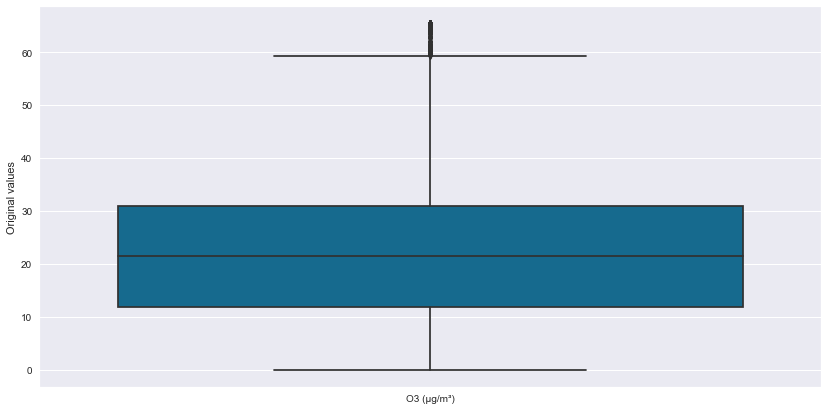

In [98]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    #'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### SO2

In [99]:
data = df_total['SO2 (µg/m³)'].values

In [100]:
outlier_datapoint = detect_outlier(data)
min_val = min(outlier_datapoint)
max_val = max(outlier_datapoint)

print('Min value: ', min_val)
print('Max value: ', max_val)
print('All outliers: ', outlier_datapoint)

Min value:  21.06
Max value:  44.68999999999999
All outliers:  [28.38, 37.69, 44.68999999999999, 28.4, 22.13, 25.25, 24.200000000000003, 22.23, 21.7, 22.210000000000004, 24.56, 26.870000000000005, 25.67, 24.29, 25.299999999999997, 21.770000000000003, 22.450000000000003, 21.420000000000005, 22.1, 29.21, 32.42, 29.030000000000005, 32.79, 21.47, 24.220000000000002, 28.44, 25.03, 23.49, 40.62, 35.97, 21.520000000000003, 22.5, 21.06, 21.56, 22.28, 27.24, 33.98, 21.430000000000003, 24.47, 22.53, 22.36, 37.22, 28.46, 22.460000000000004, 23.24, 23.060000000000002, 22.66, 22.700000000000003, 24.56, 23.320000000000004, 22.12, 27.67, 26.959999999999997, 23.960000000000004, 23.590000000000003, 23.78, 21.530000000000005, 23.12, 26.66, 21.240000000000002, 32.96, 29.57, 22.03, 32.31, 26.949999999999996, 24.76, 29.93, 32.17, 21.290000000000003, 21.32, 27.14, 31.11, 25.514000000000003, 25.48, 24.220000000000002, 21.62, 25.61, 28.619999999999997, 21.770000000000003, 28.65, 27.610000000000003, 26.19, 23.

***Replacing outliers with `min_val` and `max_val` respectivly***

In [101]:
df_total.loc[df_total['SO2 (µg/m³)'] > min_val,'SO2 (µg/m³)'] = min_val

In [102]:
#df_total.loc[df_total['WG (m/s)'] < max_val,'WG (m/s)'] = max_val

***Testing if there are outliers***

In [103]:
df_total[df_total['SO2 (µg/m³)'] > min_val]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [104]:
#df_total[df_total['WG (m/s)'] < max_val]

***Checking `Max Value` and `Mind Value`, `Boxplotting`***

In [105]:
max(df_total['SO2 (µg/m³)'])

21.06

In [106]:
min(df_total['SO2 (µg/m³)'])

0.0

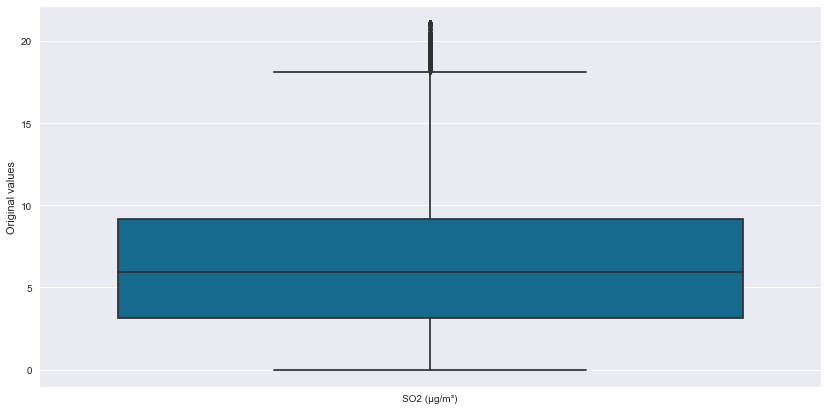

In [107]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    #'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

####  Rainfall

In [108]:
data = df_total['Niederschlag (l/m²)'].values

In [109]:
outlier_datapoint = detect_outlier(data)
min_val = min(outlier_datapoint)
max_val = max(outlier_datapoint)

print('Min value: ', min_val)
print('Max value: ', max_val)
print('All outliers: ', outlier_datapoint)

Min value:  11.5
Max value:  51.1
All outliers:  [11.586, 13.302, 16.4, 18.39, 12.849999999999998, 16.32, 13.73, 12.06, 32.41, 15.67, 19.26, 17.93, 21.41, 18.89, 14.93, 29.490000000000002, 20.1, 19.54, 18.27, 11.54, 15.289999999999997, 13.13, 12.36, 12.8, 18.46, 11.69, 15.94, 14.519999999999998, 18.89, 18.46, 20.32, 14.27, 18.08, 12.73, 13.969999999999999, 37.26, 14.93, 35.68, 21.76, 11.97, 23.55, 11.61, 21.04, 15.23, 14.49, 22.31, 12.09, 12.67, 14.1, 11.61, 12.46, 12.2, 30.499999999999996, 12.52, 12.19, 18.42, 11.9, 29.26, 13.89, 19.14, 13.06, 16.16, 11.65, 20.63, 15.27, 15.84, 14.030000000000001, 14.119999999999997, 13.43, 12.58, 16.08, 13.5, 20.67, 16.88, 40.81, 20.02, 22.01, 17.06, 21.93, 16.26, 14.590000000000002, 19.83, 13.8, 17.93, 15.650000000000002, 18.22, 15.26, 14.079999999999998, 12.55, 12.44, 12.72, 13.420000000000002, 19.85, 15.84, 15.920000000000002, 16.52, 11.57, 17.22, 18.93, 14.249999999999998, 15.77, 12.53, 13.150000000000002, 16.02, 25.5, 22.22, 23.59, 17.17, 18.28,

***Replacing outliers with `min_val` and `max_val` respectivly***

In [110]:
df_total.loc[df_total['Niederschlag (l/m²)'] > min_val,'Niederschlag (l/m²)'] = min_val

In [111]:
#df_total.loc[df_total['WG (m/s)'] < max_val,'WG (m/s)'] = max_val

***Testing if there are outliers***

In [112]:
df_total[df_total['Niederschlag (l/m²)'] > min_val]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


In [113]:
#df_total[df_total['WG (m/s)'] < max_val]

***Checking `Max Value` and `Mind Value`, `Boxplotting`***

In [114]:
max(df_total['Niederschlag (l/m²)'])

11.5

In [115]:
min(df_total['Niederschlag (l/m²)'])

0.0

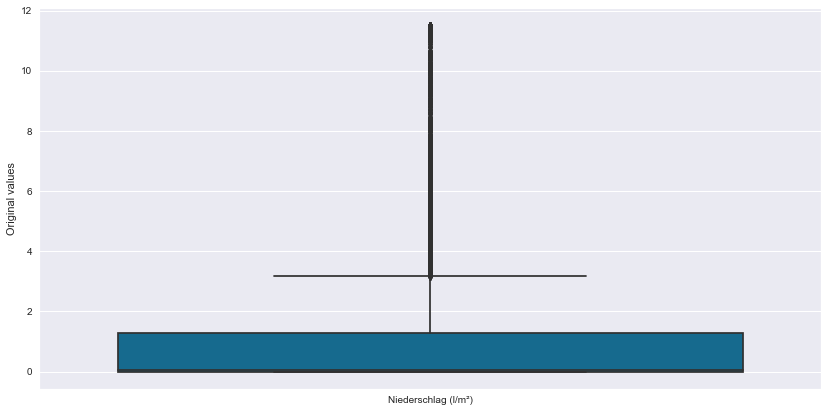

In [116]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    #'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

### Outlier Handling Using IQR

#### Pressure


In [117]:
data_IQR = df_total['Druck (hPa)'].values

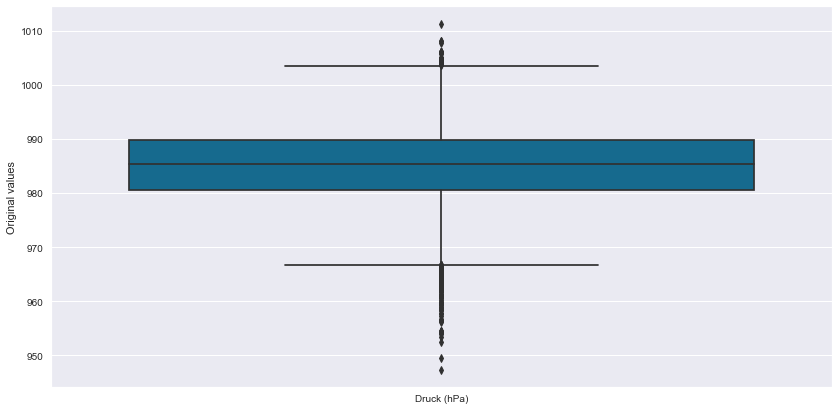

In [118]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    #'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

IQR tells how spread the middle values are. It can be used to tell when a value is too far from the middle.
An outlier is a point which falls more than 1.5 times the interquartile range above the third quartile or below the first quartile.

In [119]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  966.7625000000002
Upper bound:  1003.6224999999998


Anything outside of `lower_bound` and `upper_bound` is an outlier.

In [120]:
df_total[(df_total['NO2 (µg/m³)'] < lower_bound) | (df_total['NO2 (µg/m³)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
0,2000-01-01,3.718,5.700,2.1380,86.830,1.959896,7.4500,234.922917,991.800,20.2840,...,17.6266,24.236,13.600,10.38000,0.910900,3.5892,-85.6520,11.3772,9.3750,71895.6
1,2000-01-02,3.848,6.706,1.2990,90.690,2.172913,7.8910,222.511250,996.900,27.8120,...,14.2886,28.698,16.910,10.74000,0.887000,3.5212,-124.1220,12.3972,7.5428,67668.4
2,2000-01-03,1.463,2.706,0.4088,88.480,2.295208,6.0300,220.181250,996.200,25.7540,...,19.0638,35.336,15.400,10.29000,0.839400,0.8398,-9.8208,19.9480,11.1810,64946.0
3,2000-01-04,4.934,7.747,0.8828,77.370,3.574979,9.7030,220.885417,989.900,29.5224,...,8.2660,24.210,22.430,13.42000,0.782200,1.4894,5.3120,11.4780,7.6820,84214.4
4,2000-01-05,6.917,10.070,2.0340,83.520,2.237208,9.1150,220.554167,989.700,32.6984,...,11.3496,26.208,16.030,14.27000,1.189000,4.3200,-21.6198,12.9260,6.6800,75317.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7453,2020-05-28,17.300,21.800,12.4000,48.900,2.400000,6.1000,28.000000,996.450,235.7000,...,4.2000,23.500,24.766,2.13052,0.119944,0.0000,136.1000,13.9400,8.9128,61991.6
7454,2020-05-29,16.200,21.200,9.4000,44.800,2.200000,5.6000,129.000000,993.430,237.9000,...,2.8000,18.700,24.856,8.79640,0.173780,0.0000,105.5000,21.6300,8.6104,69415.0
7455,2020-05-30,15.900,20.600,9.3000,47.400,2.400000,7.1000,27.000000,989.460,215.4000,...,2.4000,18.400,23.862,2.93716,0.130298,0.0000,104.9000,13.1080,7.8328,76189.4
7456,2020-05-31,16.700,21.900,10.4000,42.700,2.000000,5.3000,61.000000,988.270,258.8000,...,1.6000,13.000,23.382,3.89840,0.130196,0.0000,131.8000,11.5820,7.4728,62979.0


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [121]:
df_total.loc[df_total['Druck (hPa)'] > upper_bound,'Druck (hPa)'] = upper_bound

In [122]:
df_total.loc[df_total['Druck (hPa)'] < lower_bound,'Druck (hPa)'] = lower_bound

***Testing if there are values outside the range***

In [123]:
df_total[(df_total['Druck (hPa)'] < lower_bound) | (df_total['Druck (hPa)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [124]:
max(df_total['Druck (hPa)'])

1003.6224999999998

In [125]:
min(df_total['Druck (hPa)'])

966.7625000000002

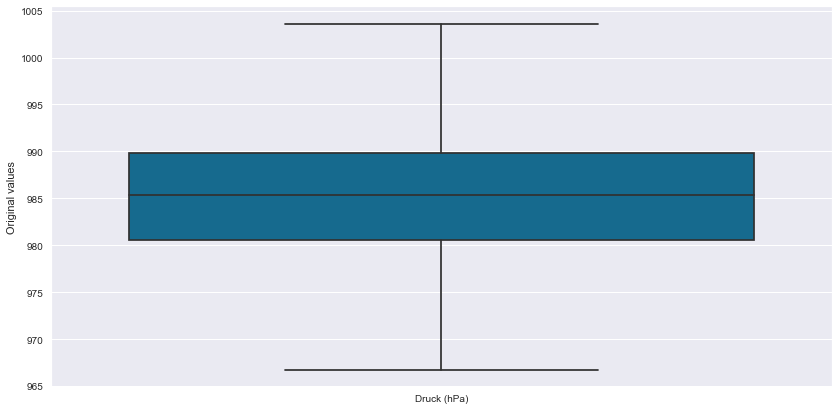

In [126]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    #'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### Global Radiation


In [127]:
data_IQR = df_total['Globalstr. (W/m²)'].values

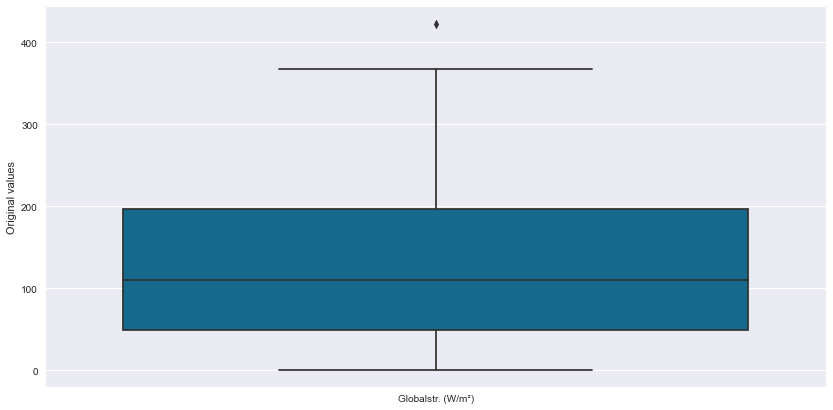

In [128]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    #'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

In [129]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  -173.79375000000002
Upper bound:  419.15625


In [130]:
df_total[(df_total['Globalstr. (W/m²)'] < lower_bound) | (df_total['Globalstr. (W/m²)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges
164,2000-06-13,25.87,28.84,21.67,46.31,2.269258,7.059,214.870308,992.2,422.9,...,5.043,32.47,63.77,3.937,1.272,0.469,158.82,13.342,11.0,66774.6


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [131]:
df_total.loc[df_total['Globalstr. (W/m²)'] > upper_bound,'Globalstr. (W/m²)'] = upper_bound

In [132]:
df_total.loc[df_total['Globalstr. (W/m²)'] < lower_bound,'Globalstr. (W/m²)'] = lower_bound

***Testing if there are values outside the range***

In [133]:
df_total[(df_total['Globalstr. (W/m²)'] < lower_bound) | (df_total['Globalstr. (W/m²)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [134]:
max(df_total['Globalstr. (W/m²)'])

419.15625

In [135]:
min(df_total['Globalstr. (W/m²)'])

0.8552

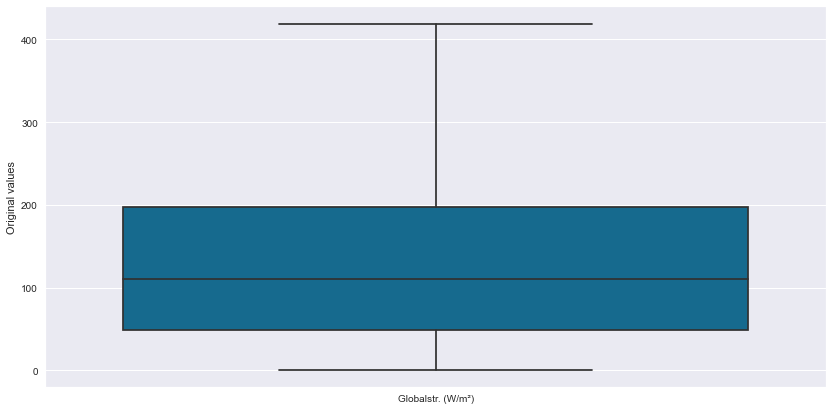

In [136]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    #'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### UV Radiation


`UVA Radiation`

In [137]:
data_IQR = df_total['UVA-Str. (W/m²)'].values

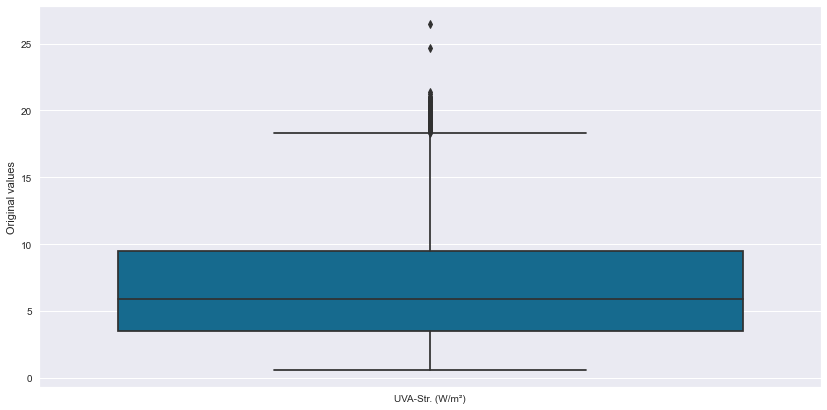

In [138]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    #'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

In [139]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  -5.347500000000001
Upper bound:  18.3425


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [140]:
df_total.loc[df_total['UVA-Str. (W/m²)'] > upper_bound,'UVA-Str. (W/m²)'] = upper_bound

In [141]:
df_total.loc[df_total['UVA-Str. (W/m²)'] < lower_bound,'UVA-Str. (W/m²)'] = lower_bound

***Testing if there are values outside the range***

In [142]:
df_total[(df_total['UVA-Str. (W/m²)'] < lower_bound) | (df_total['UVA-Str. (W/m²)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [143]:
max(df_total['UVA-Str. (W/m²)'])

18.3425

In [144]:
min(df_total['UVA-Str. (W/m²)'])

0.62

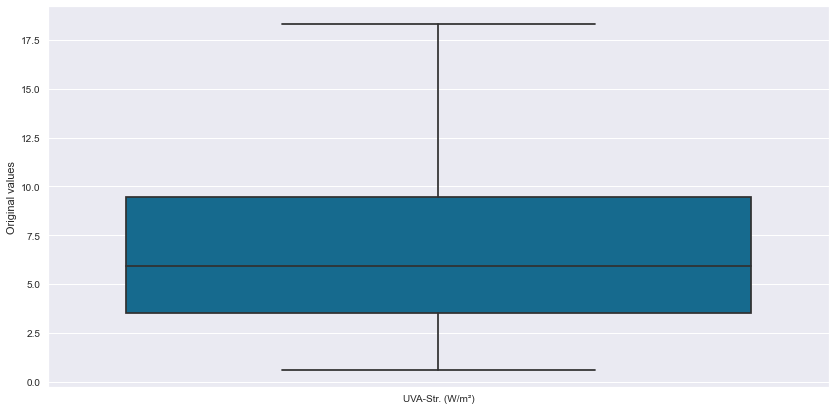

In [145]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    #'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

`UVB Radiation`

In [146]:
data_IQR = df_total['UVB-Str. (W/m²)'].values

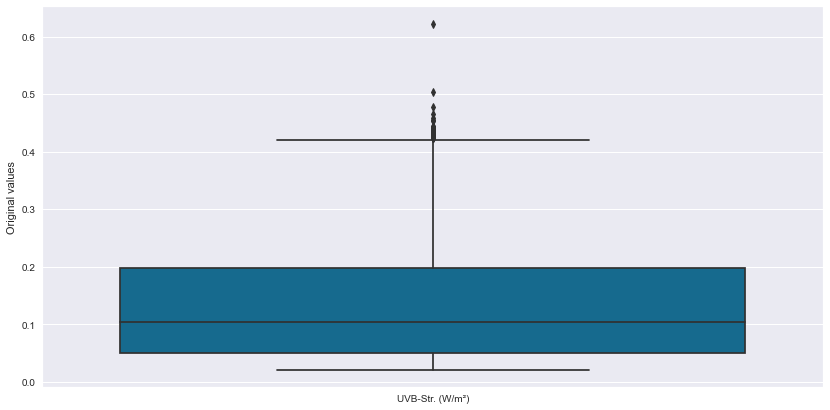

In [147]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    #'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

In [148]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  -0.1746125
Upper bound:  0.4216875


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [149]:
df_total.loc[df_total['UVB-Str. (W/m²)'] > upper_bound,'UVB-Str. (W/m²)'] = upper_bound

In [150]:
df_total.loc[df_total['UVB-Str. (W/m²)'] < lower_bound,'UVB-Str. (W/m²)'] = lower_bound

***Testing if there are values outside the range***

In [151]:
df_total[(df_total['UVB-Str. (W/m²)'] < lower_bound) | (df_total['UVB-Str. (W/m²)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [152]:
max(df_total['UVB-Str. (W/m²)'])

0.4216875

In [153]:
min(df_total['UVB-Str. (W/m²)'])

0.02103

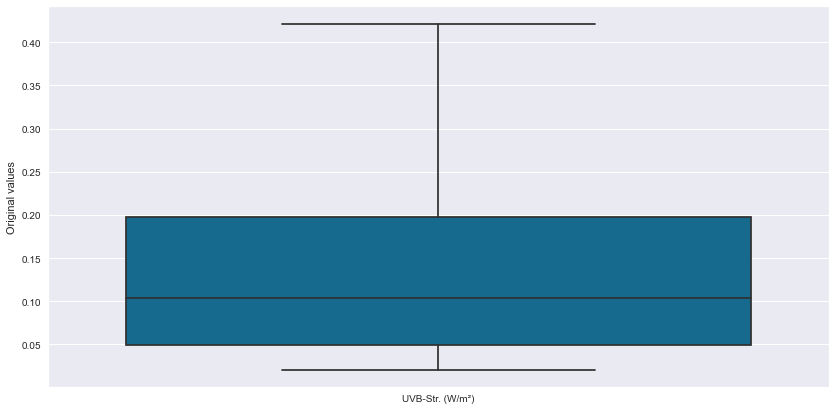

In [154]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    #'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### NO

In [155]:
data_IQR = df_total['NO (µg/m³)'].values

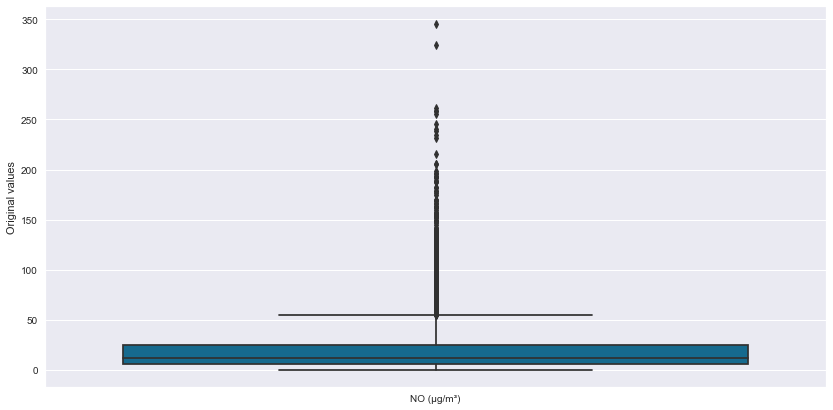

In [156]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
#     'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

In [157]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  -24.275
Upper bound:  54.556999999999995


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [158]:
df_total.loc[df_total['NO (µg/m³)'] > upper_bound,'NO (µg/m³)'] = upper_bound

In [159]:
df_total.loc[df_total['NO (µg/m³)'] < lower_bound,'NO (µg/m³)'] = lower_bound

***Testing if there are values outside the range***

In [160]:
df_total[(df_total['NO (µg/m³)'] < lower_bound) | (df_total['NO (µg/m³)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [161]:
max(df_total['NO (µg/m³)'])

54.556999999999995

In [162]:
min(df_total['NO (µg/m³)'])

0.04722000000000004

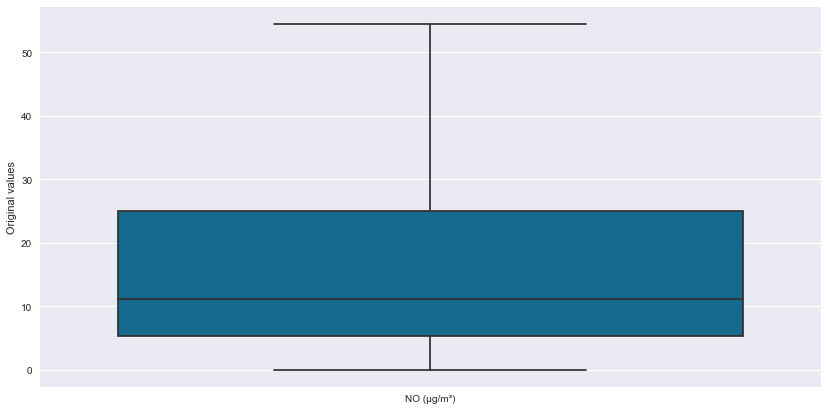

In [163]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    #'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### CO

In [164]:
data_IQR = df_total['CO (mg/m³)'].values

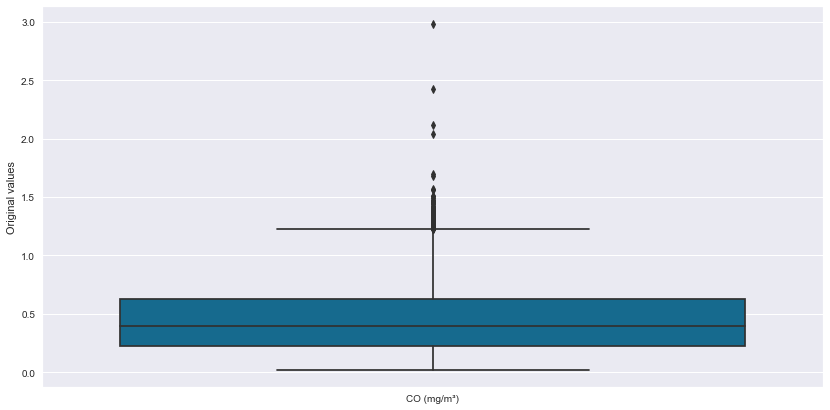

In [165]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
#     'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

In [166]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  -0.37067624999999976
Upper bound:  1.2229577499999997


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [167]:
df_total.loc[df_total['CO (mg/m³)'] > upper_bound,'CO (mg/m³)'] = upper_bound

In [168]:
df_total.loc[df_total['CO (mg/m³)'] < lower_bound,'CO (mg/m³)'] = lower_bound

***Testing if there are values outside the range***

In [169]:
df_total[(df_total['CO (mg/m³)'] < lower_bound) | (df_total['CO (mg/m³)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [170]:
max(df_total['CO (mg/m³)'])

1.2229577499999997

In [171]:
min(df_total['CO (mg/m³)'])

0.02383

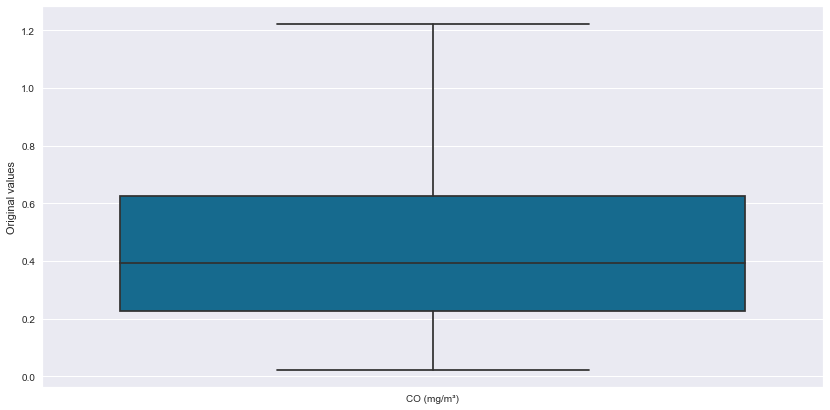

In [172]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    #'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### Radiation Balance

In [173]:
data_IQR = df_total['Str.-Bilanz (W/m²)'].values

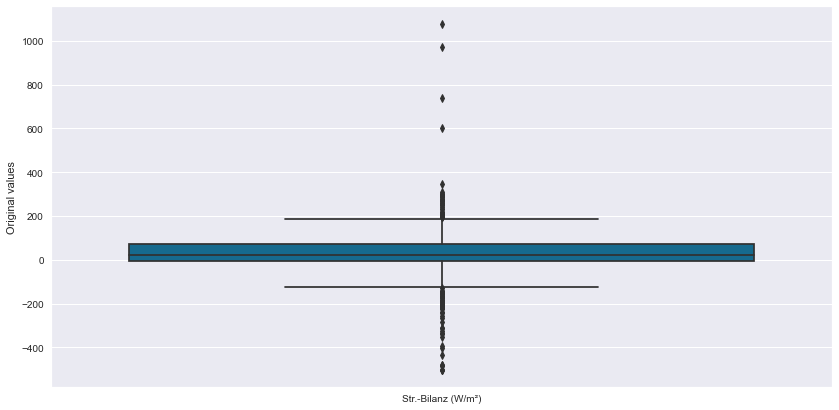

In [174]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
#     'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

In [175]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  -127.24312500000002
Upper bound:  195.41387499999996


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [176]:
df_total.loc[df_total['Str.-Bilanz (W/m²)'] > upper_bound,'Str.-Bilanz (W/m²)'] = upper_bound

In [177]:
df_total.loc[df_total['Str.-Bilanz (W/m²)'] < lower_bound,'Str.-Bilanz (W/m²)'] = lower_bound

***Testing if there are values outside the range***

In [178]:
df_total[(df_total['Str.-Bilanz (W/m²)'] < lower_bound) | (df_total['Str.-Bilanz (W/m²)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [179]:
max(df_total['Str.-Bilanz (W/m²)'])

195.41387499999996

In [180]:
min(df_total['Str.-Bilanz (W/m²)'])

-127.24312500000002

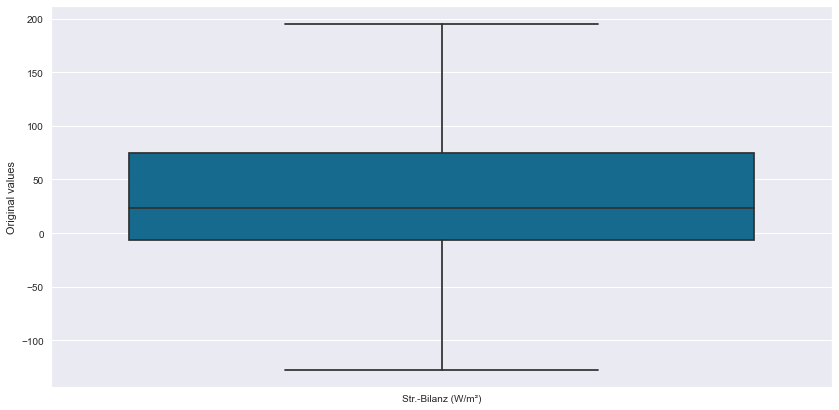

In [181]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    #'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### PM2.5

In [182]:
data_IQR = df_total['PM2.5 (µg/m³)'].values

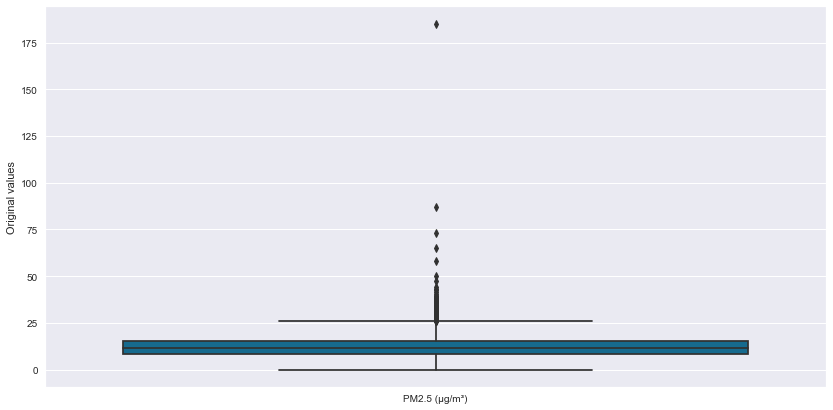

In [183]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
#     'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

In [184]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  -2.2222500000000007
Upper bound:  26.13335


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [185]:
df_total.loc[df_total['PM2.5 (µg/m³)'] > upper_bound,'PM2.5 (µg/m³)'] = upper_bound

In [186]:
df_total.loc[df_total['PM2.5 (µg/m³)'] < lower_bound,'PM2.5 (µg/m³)'] = lower_bound

***Testing if there are values outside the range***

In [187]:
df_total[(df_total['PM2.5 (µg/m³)'] < lower_bound) | (df_total['PM2.5 (µg/m³)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [188]:
max(df_total['PM2.5 (µg/m³)'])

26.13335

In [189]:
min(df_total['PM2.5 (µg/m³)'])

0.0

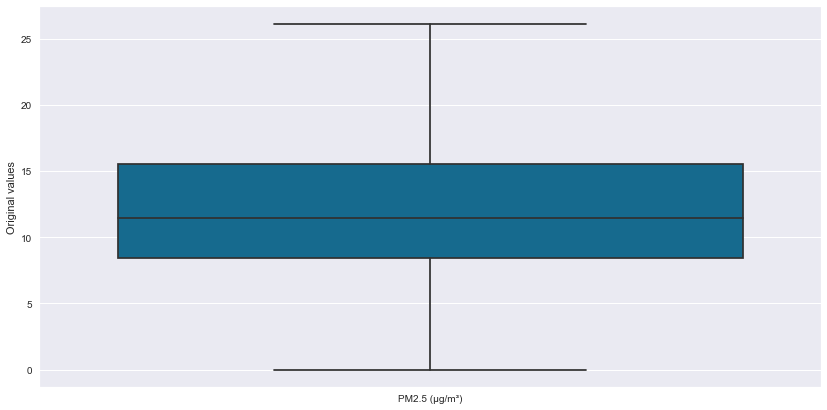

In [190]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    #'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### PM10

In [191]:
data_IQR = df_total['PM10 (µg/m³)'].values

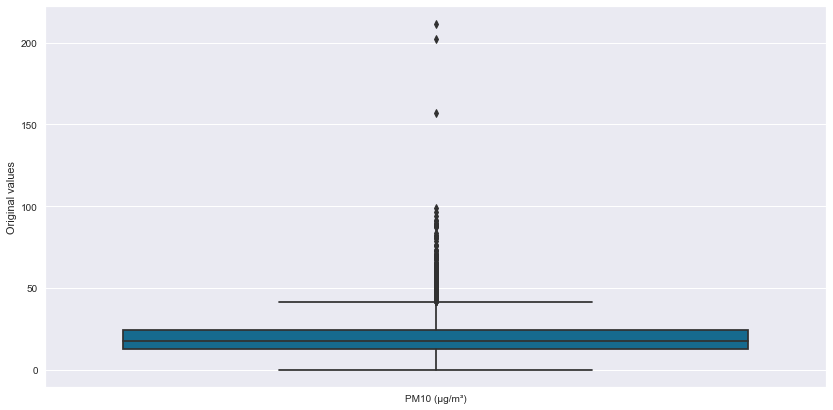

In [192]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
#     'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

In [193]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  -4.996499999999996
Upper bound:  41.610699999999994


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [194]:
df_total.loc[df_total['PM10 (µg/m³)'] > upper_bound,'PM10 (µg/m³)'] = upper_bound

In [195]:
df_total.loc[df_total['PM10 (µg/m³)'] < lower_bound,'PM10 (µg/m³)'] = lower_bound

***Testing if there are values outside the range***

In [196]:
df_total[(df_total['PM10 (µg/m³)'] < lower_bound) | (df_total['PM10 (µg/m³)'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [197]:
max(df_total['PM10 (µg/m³)'])

41.610699999999994

In [198]:
min(df_total['PM10 (µg/m³)'])

0.0

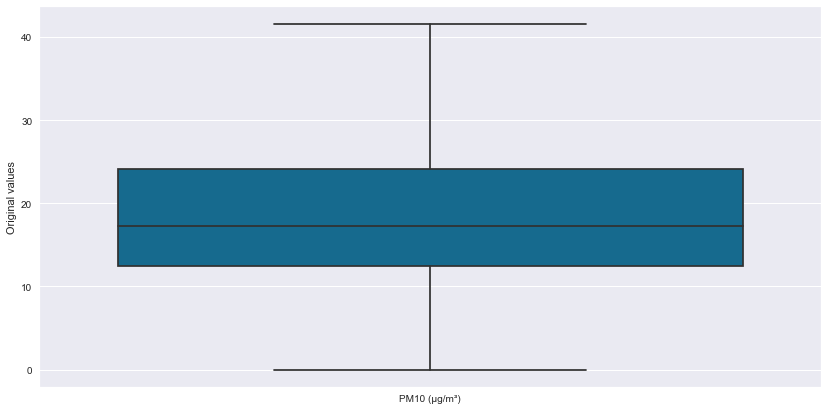

In [199]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    #'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

#### Traffic Amount

In [200]:
data_IQR = df_total['KFZ_ges'].values

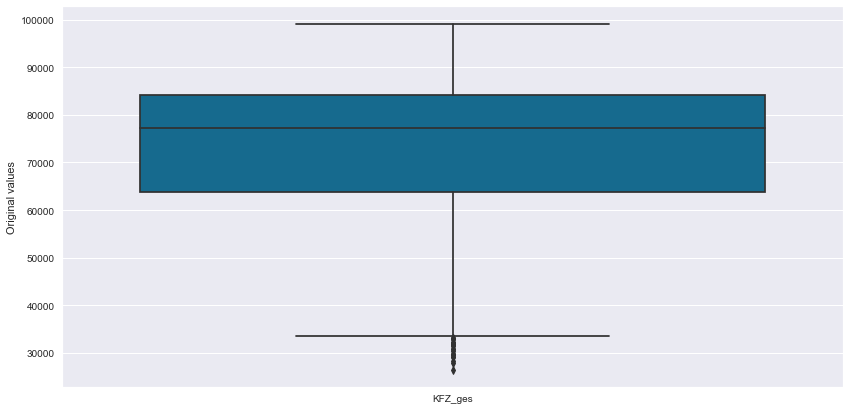

In [201]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
#     'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

In [202]:
sorted(data_IQR) #sorting the dataset

q1, q3= np.percentile(data_IQR,[25,75]) #finding first quartile and third quartile

iqr = q3 - q1 #find the IQR which is the difference between third and first quartile

lower_bound = q1 -(1.5 * iqr) #find lower bound
upper_bound = q3 +(1.5 * iqr) #find upper bound
print('Lower bound: ', lower_bound)
print('Upper bound: ', upper_bound)

Lower bound:  33286.875
Upper bound:  114775.875


***Replacing all the values higher then `upper_bound` with the value of `upper_bound`***

In [203]:
df_total.loc[df_total['KFZ_ges'] > upper_bound,'KFZ_ges'] = upper_bound

In [204]:
df_total.loc[df_total['KFZ_ges'] < lower_bound,'KFZ_ges'] = lower_bound

***Testing if there are values outside the range***

In [205]:
df_total[(df_total['KFZ_ges'] < lower_bound) | (df_total['KFZ_ges'] > upper_bound)]

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),KFZ_ges


***Testing if the highest value in the row belowe is not higher then `upper_bound`***

In [206]:
max(df_total['KFZ_ges'])

99162.0

In [207]:
min(df_total['KFZ_ges'])

33286.875

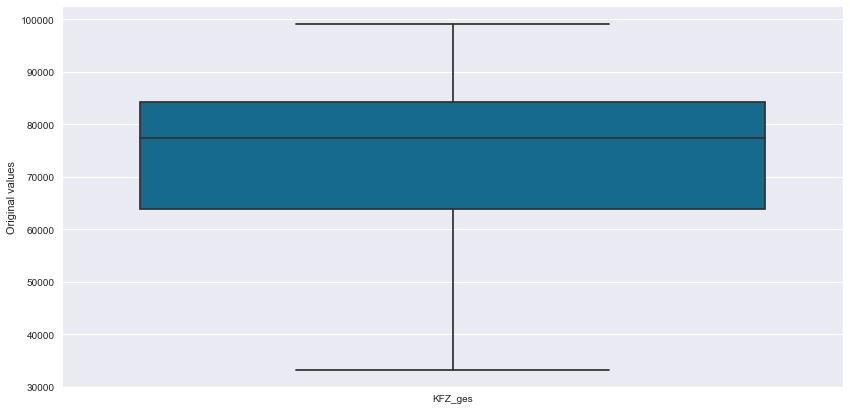

In [208]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    'WG (m/s)',
    'WG (m/s).1',
    'WR (Grad)',
    'Druck (hPa)',
    'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    'NO (µg/m³)',
    'NO2 (µg/m³)',
    'O3 (µg/m³)',
    'SO2 (µg/m³)',
    'CO (mg/m³)',
    'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    #'KFZ_ges'
]))
plt.ylabel("Original values")
plt.show()

### Outlier Handling Using Log

For the sake of completeness we show in the follwing the method to handle outliers with the log method but in our case we won't use it.

In [209]:
#df_total['WG (m/s)'] = [np.log(x) for x in df_total['WG (m/s)']]
#df_total['NO (µg/m³)'] = [np.log(x) for x in df_total['NO (µg/m³)']]
#df_total['NO2 (µg/m³)'] = [np.log(x) for x in df_total['NO2 (µg/m³)']]
#df_total['SO2 (µg/m³)'] = [np.log(x) for x in df_total['SO2 (µg/m³)']]
#df_total['Niederschlag (l/m²)'] = [np.log(x) for x in df_total['Niederschlag (l/m²)']]
#df_total['PM10 (µg/m³)'] = [np.log(x) for x in df_total['PM10 (µg/m³)']]

## Plots after data preparation

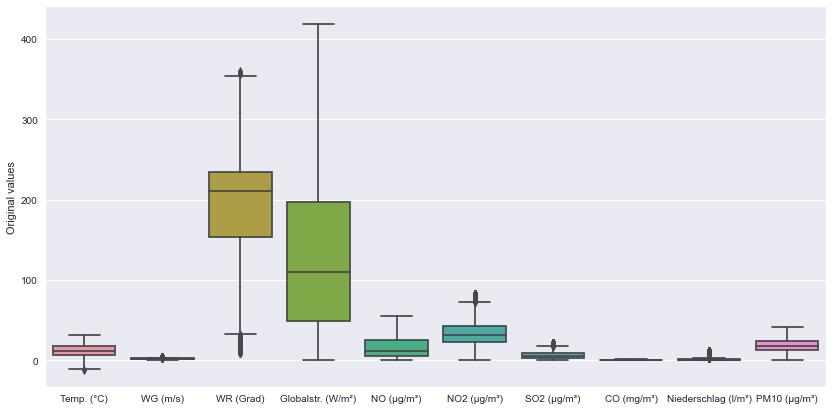

In [210]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_total.drop(columns=[
    'Datum',
    #'Temp. (°C)',
    'Temp. (°C).1',
    'Temp. (°C).2',
    'Feuchte (%)',
    #'WG (m/s)',
    'WG (m/s).1',
    #'WR (Grad)',
    'Druck (hPa)',
    #'Globalstr. (W/m²)',
    'UVA-Str. (W/m²)',
    'UVB-Str. (W/m²)',
    #'NO (µg/m³)',
    #'NO2 (µg/m³)',
    'O3 (µg/m³)',
    #'SO2 (µg/m³)',
    #'CO (mg/m³)',
    #'Niederschlag (l/m²)',
    'Str.-Bilanz (W/m²)',
    #'PM10 (µg/m³)',
    'PM2.5 (µg/m³)',
    'KFZ_ges'
]))
#plt.title("Distribution of normalized temperature, humidity and windspeed")
plt.ylabel("Original values")
plt.show()

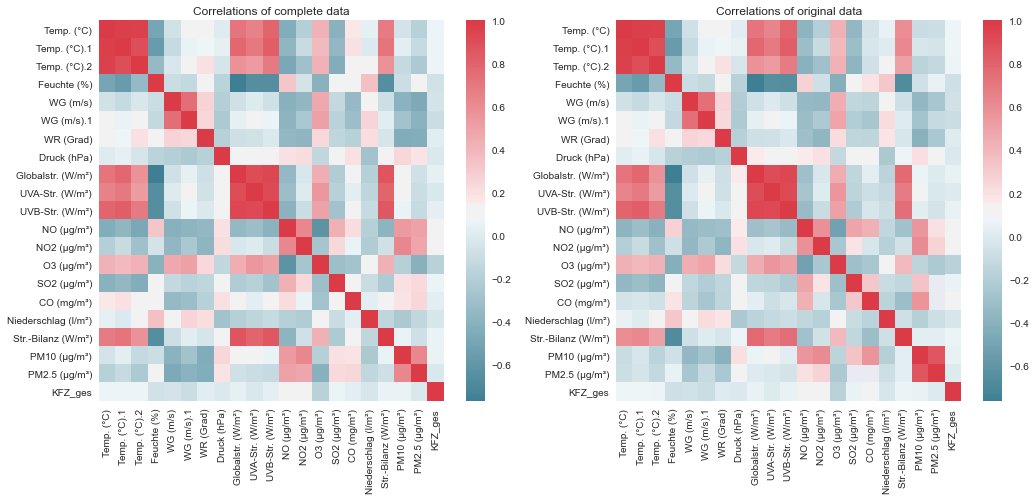

In [211]:
corr_total = df_total.corr()
corr_total_original = df_total_original.corr()

fig, ax = plt.subplots(1, 2, figsize=(17, 7))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_total, cmap=colormap, annot=False, fmt=".2f", ax=ax[0]).set_title("Correlations of complete data")
sns.heatmap(corr_total_original, cmap=colormap, annot=False, fmt=".2f", ax=ax[1]).set_title("Correlations of original data")
plt.show()

We see that the data "characters" and patterns after completing missing data and outlier handling has not changed significantly so that we can continue with the completed data.

In the following we see that the time gaps for particultes were filled by the imputer function.

First we show the whole period 2000-2020.

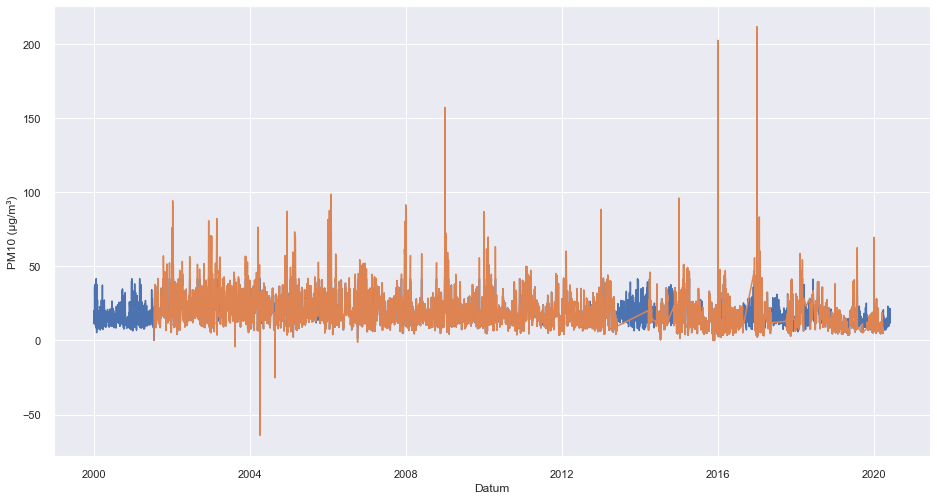

In [212]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total)
ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total_original)

We can zoom in for period starting on 01 January 2013.

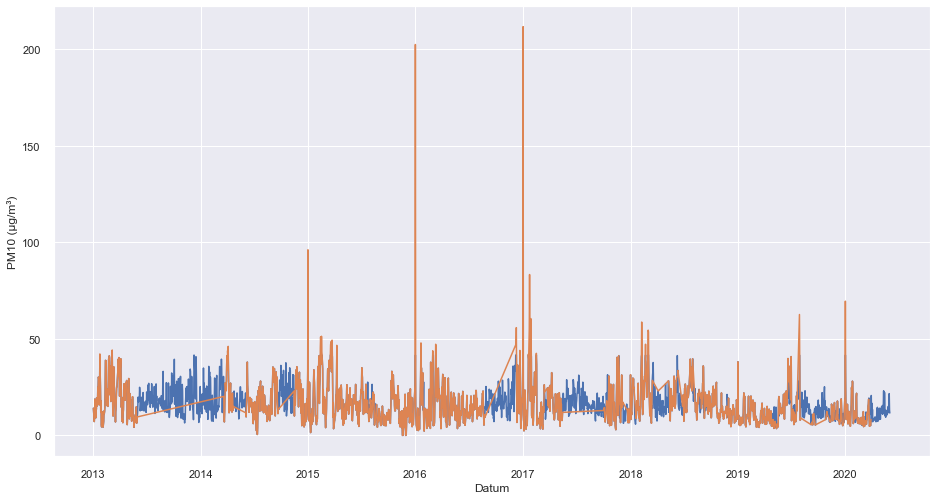

In [213]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total[df_total["Datum"] > '2013-01-01 00:00:00'])
ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total_original[df_total_original["Datum"] > '2013-01-01 00:00:00'])

Further zoom in for period 2018-2019.

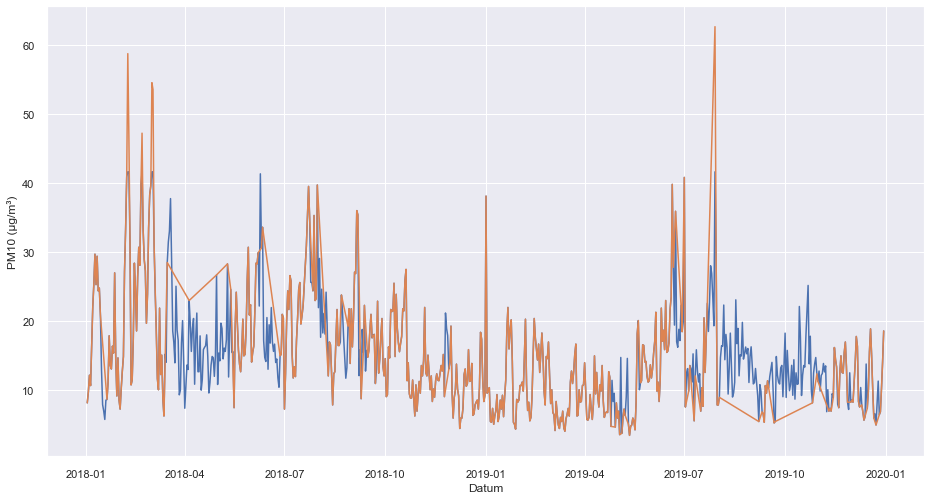

In [214]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total[(df_total["Datum"] > '2018-01-01 00:00:00')&(df_total["Datum"] < '2019-12-31 00:00:00')])
ax=sns.lineplot(x="Datum", y="PM10 (µg/m³)", data=df_total_original[(df_total_original["Datum"] > '2018-01-01 00:00:00')&(df_total_original["Datum"] < '2019-12-31 00:00:00')])

We also plot and analyze the data for traffic. Here we realized that the imputting method does not work optimally for this attribute. In the period 2000-2002 we see an decreasing trend of the traffic data. We would expect an increase trend in analogy to the real data 2003-2018. The populated period at the end of the time series also seem to to decrease. Here we also would expect an increase behaviour.  
In this case we would chose another imputing method based on a linear regression approach. Due to the restricted time and the higher focus an Machine Learning we will continue with this data though. 

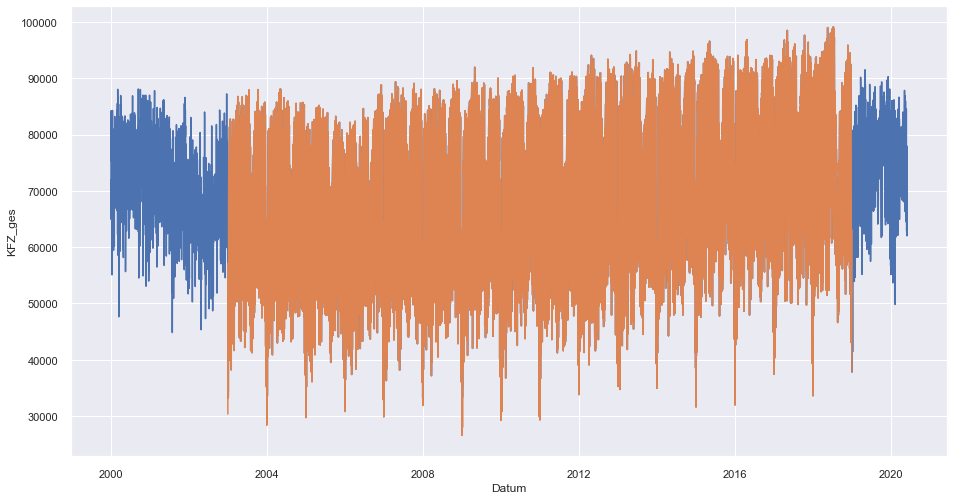

In [215]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="KFZ_ges", data=df_total)
ax=sns.lineplot(x="Datum", y="KFZ_ges", data=df_total_original)

## Features Selection

The goals of the feature selections are:
- Eliminate redundancies and correlations of different features, e.g. at the level of temperature and radiation parameters
- Reduce computational time / cost
- Improve the prediction accuracy 
- Produce a more interpretable model

We also realized that for some features a further feature processing would be helpful. For example the feature `Wind Direction` could be transformed in 8 cardinal points like North-East, South, South-West etc. Due to the restricted time and the higher focus an Machine Learning we will continue with this data. 

Basesd on Scikit-Learn the feature importance is calculated with `sklearn.feature_selection.mutual_info_regression` (more information can be found here on [Scikit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html?highlight=mutual_info_regression#sklearn.feature_selection.mutual_info_regression)).  
The visualization is generated with the help of [yellowbrick](https://www.scikit-yb.org/en/latest/api/target/feature_correlation.html).

In [ ]:
!pip install yellowbrick

**In our use case there are no discrete features. Therefore we set all items in the discrete list to False.**

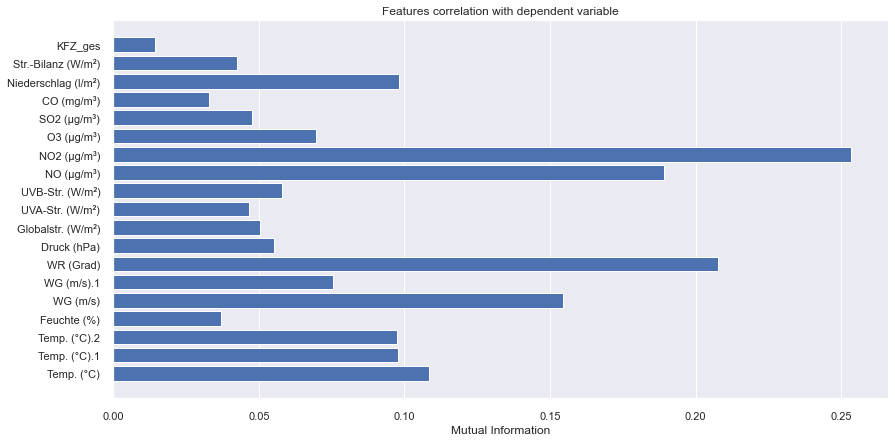

In [216]:
X, y = df_total.drop(['Datum','PM10 (µg/m³)','PM2.5 (µg/m³)'], axis=1).to_numpy(), df_total['PM10 (µg/m³)'].to_numpy()

# Create a list of the feature names
features = np.array(list(df_total.drop(['Datum','PM10 (µg/m³)','PM2.5 (µg/m³)'], axis=1)))

# Create a list of the discrete features
discrete = [False for _ in range(len(features))]
#discrete[1] = True #there are no discrete features in our use case, all of them are continous

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=features, size=(1000, 500))

visualizer.fit(X, y, discrete_features=discrete, random_state=0)
visualizer.show()

In the the next step we have a look on the Pearson's correlations.  
Here, in contrary to the approach above ('mututal information for regresson'), this approach handles continous and dicrete variables equally.  
The Pearson's correlation further helps to understand the direction of dependencies between features and the target variable. 

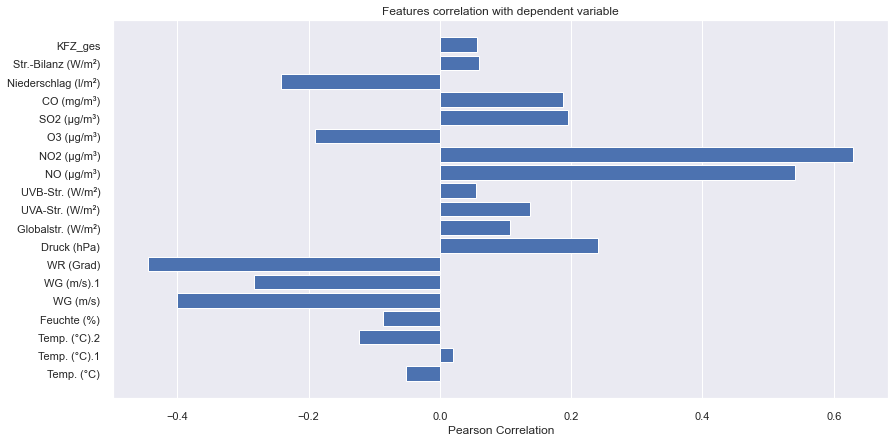

In [217]:
X, y = df_total.drop(['Datum','PM10 (µg/m³)','PM2.5 (µg/m³)'], axis=1).to_numpy(), df_total['PM10 (µg/m³)'].to_numpy()

# Create a list of the feature names
features = np.array(list(df_total.drop(['Datum','PM10 (µg/m³)','PM2.5 (µg/m³)'], axis=1)))

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='pearson', labels=features, size=(1000, 500))

visualizer.fit(X, y)
visualizer.show()

The first analysis based on `Mutual Information` shows a higher significance (>0.1) of following parameter:  

- NO
- NO2
- Wind Direction
- Wind Speed (mean)
- Temperature (mean)

The second analysis based on `Pearson's Correlation` and recommendations of Cohen* we decided to chose the features with correlations higher than 0.2 (absolute values):

- Rainfall
- Wind Direction
- Wind Speed (mean)
- Wind Speed (max)
- NO2
- NO
- Pressure



*According to Cohen r = 0.1 indicates a small impact, r = 0.3 a middle impact and r = 0.5 a strong impact. 

In the case of temperature, we only chose one temperature attribute, the `Temperature (mean)`. The other temperature related attributes flow into the calculation of the mean value and therefore can be neglected.  

For `Wind Speed` we also take the mean value, which shows a better dependency / correlation to the target value.  

The attribute that we expected to have the highest impact, `traffic volume`, shows indeed a very poor impact on the target variable `particulates`. Therefore, this attribute will be dropped.

**According to the feature selection procedure used above, we decide on the following variables and save them in a new data frame df_for_ML.**

In [218]:
df_for_ML = df_total[['Datum', 
                      'Temp. (°C)', 
                      #'Temp. (°C).1', 
                      #'Temp. (°C).2',  
                      #'Feuchte (%)',
                      'WG (m/s)', 
                      #'WG (m/s).1', 
                      'WR (Grad)', 
                      'Druck (hPa)',
                      #'Globalstr. (W/m²)', 
                      #'UVA-Str. (W/m²)', 
                      #'UVB-Str. (W/m²)',  
                      'NO (µg/m³)', 
                      'NO2 (µg/m³)', 
                      #'O3 (µg/m³)', 
                      #'SO2 (µg/m³)', 
                      #'CO (mg/m³)',
                      'Niederschlag (l/m²)', 
                      #'Str.-Bilanz (W/m²)', 
                      'PM10 (µg/m³)',
                      #'PM2.5 (µg/m³)',  
                      #'KFZ_ges'
                     ]]

In [219]:
df_for_ML.head(5)

,Datum,Temp. (°C),WG (m/s),WR (Grad),Druck (hPa),NO (µg/m³),NO2 (µg/m³),Niederschlag (l/m²),PM10 (µg/m³)
0,2000-01-01,3.718,1.959896,234.922917,991.8,17.6266,24.236,3.5892,11.3772
1,2000-01-02,3.848,2.172913,222.511250,996.9,14.2886,28.698,3.5212,12.3972
2,2000-01-03,1.463,2.295208,220.181250,996.2,19.0638,35.336,0.8398,19.9480
3,2000-01-04,4.934,3.574979,220.885417,989.9,8.2660,24.210,1.4894,11.4780
4,2000-01-05,6.917,2.237208,220.554167,989.7,11.3496,26.208,4.3200,12.9260


Before we export the dataframe to a csv file we cleanse the column names. 

In [220]:
df_for_ML.columns

Index(['Datum', 'Temp. (°C)', 'WG (m/s)', 'WR (Grad)', 'Druck (hPa)',
       'NO (µg/m³)', 'NO2 (µg/m³)', 'Niederschlag (l/m²)', 'PM10 (µg/m³)'],
      dtype='object')

In [221]:
newColumnNames=['Datum', 'Temp', 'WG', 'WR', 'Druck',
       'NO', 'NO2',
       'Niederschlag', 'PM10']

In [222]:
df_for_ML.columns = newColumnNames

In [223]:
df_for_ML.columns

Index(['Datum', 'Temp', 'WG', 'WR', 'Druck', 'NO', 'NO2', 'Niederschlag',
       'PM10'],
      dtype='object')

Now we export the dataframe to a csv.

In [224]:
df_for_ML.to_csv('df_for_ML.csv', index=False)